In this challenge, you'll work with the [Life Expectancy dataset from Kaggle](https://www.kaggle.com/kumarajarshi/life-expectancy-who/home). The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

* Data ranges from 2000-2015

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

__First, load the dataset:__

In [940]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
from scipy.stats import boxcox
from sklearn.preprocessing import normalize
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sqlalchemy import create_engine
import warnings
import string
import re

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Display up to 500 columns of a wide dataframe, instead of ...-ing them \n",
pd.set_option('display.max_columns', 500)

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

In [700]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Functions

In [701]:
# Pass in a dataframe, a 'key' column, a list of columns to interpolate, and the limit direction.
# Loop through all of the columns and interpolate.
# Return the updated dataframe.
def interpolate_missing(df,key_column,column_list,limit_dir,**kwargs):
    interp_how = kwargs.get('interp_how','linear')
    for each_value in df[key_column].unique():
        for column in column_list:
            mask = (df[key_column] == each_value)
            df.loc[mask, column] = df.loc[mask, column].interpolate(limit_direction=limit_dir,method=interp_how)
    return df

In [702]:
# Update missing values for a variable, based on the values of a provided list of values for a key variable.
# You can choose whether to overwrite existing values for the target variable.
#
# Ex:
# update_df_via_index(life_df,'Country',['South Sudan'],
#                    ['Alcohol','Polio','Hepatitis b','Diphtheria'],
#                    south_sudan_neighbors,debug=True)
def update_df_via_index(df,find_col,find_col_list,upd_col,neighbors,**kwargs):
    overwrite = kwargs.get('overwrite',False)
    debug = kwargs.get('debug',False)
    
    for find_col_val in find_col_list:
        print("* Updating data for {}: {}".format(find_col,find_col_val))
        for this_col in upd_col:
            if (debug):
                print("** Updating column: {}".format(this_col))
            upd_df = df.loc[(df['Country'].isin(neighbors))\
                           ][['Year',this_col]]\
                       .groupby(['Year']).mean()
            for each_year in upd_df.index:
    # Get the index for the row we want to update
                upd_index = int(df.loc[(df[find_col] == find_col_val) & (df['Year'] == each_year)].index[0])
                if (debug):
                    print("update index: {}".format(upd_index))
                    print(df.at[upd_index,this_col])
    # Don't overwrite existing values unless explicitly told to
                if (pd.isnull(df.loc[upd_index,this_col]) or overwrite):
                    df.at[upd_index,this_col] = upd_df.loc[each_year]
                else:
                    if debug:
                        print("Not overwriting existing value: {}".format(df.loc[upd_index,this_col]))

In [703]:
# Check out the distribution of a variable. Nothing fancy
def quick_distplot(series,title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.distplot(series)
    plt.suptitle(title)
    ax.set(yscale="log")
    plt.show()

In [704]:
def quick_boxplot(series,title,**kwargs):
    logscale = kwargs.get('logscale',True)
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(data=series,orient='h')
    plt.suptitle(title)
    if logscale:
        ax.set(xscale="log")
    plt.show()

In [705]:
def get_tukey(df,tukey_col):
    q75, q25 = np.percentile(df[tukey_col], [75 ,25])
    iqr = q75 - q25
    tukey_dict = {}
    for threshold in np.arange(1,5.5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
#        print("The score threshold is: {}".format(threshold))
        num_outliers = len((np.where((df[tukey_col] > max_val) | (df[tukey_col] < min_val))[0]))
#        print("Number of outliers is: {}".format(num_outliers))
        tukey_dict.update({threshold: [min_val, max_val, num_outliers]})
    return tukey_dict

In [706]:
def get_zscore(df,z_col):
    z_scores = zscore(df[z_col])
    z_dict = {}
    for threshold in range(1,5):
        print("The score threshold is: {}".format(threshold))
# !!! Unfortunately these indices do not seem to be the indices for the whole dataframe, just some subset.
        print("The indices of the outliers:")
        outlier_indices = np.where(z_scores > threshold)
        print(outlier_indices)
        num_outliers = len((np.where(z_scores > threshold)[0]))
        print("Number of outliers is: {}".format(num_outliers))
        z_dict.update({threshold: outlier_indices})
    return z_dict

In [707]:
def find_outliers(df,key_col,outl_col,**kwargs):
    return_outliers = kwargs.get('return_outliers',False)
    outliers_list = []
    for key_val in df[key_col].unique():
        outlier_tukey = get_tukey(df.loc[df[key_col] == key_val],outl_col)
        for thr_key in sorted(outlier_tukey):
            if ((outlier_tukey[thr_key][2] == 0) or (thr_key == 5.0)):
                print("{}: {}: Found {} outliers at threshold == {}: {}".format(key_col,
                                                                            key_val,
                                                                            outlier_tukey[thr_key][2],
                                                                            thr_key,
                                                                            outlier_tukey[thr_key]))
                if (thr_key != 1.0):
                    print(outlier_tukey)
                    outliers_list.append(key_val)
                break
    if return_outliers:
        return outliers_list

In [708]:
def what_is_this(x):
    try:
        if x.isnumeric():
            return True
    except AttributeError:
        return True

In [882]:
def scatterplot_vs_life_expectancy(df,not_these):
# Skip the columns on the not_these list
    for col_name in [x for x in df.columns if x not in not_these]:
        plt.figure(figsize=(10,5))
        sns.regplot('Life expectancy',col_name,data=df)
        plt.title("Scatterplot: Life expectancy vs. {}".format(col_name))

### Dataframe column names

In [709]:
# Strip leading/trailing spaces from column names.
# Turn double spaces into single spaces in column names.
# Capitalize the first word in the column name.

life_df.rename(lambda x: re.sub('\s\s',' ',x.strip().capitalize()),
                         axis='columns',
               inplace=True)
print(life_df.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult mortality',
       'Infant deaths', 'Alcohol', 'Percentage expenditure', 'Hepatitis b',
       'Measles', 'Bmi', 'Under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'Hiv/aids', 'Gdp', 'Population', 'Thinness 1-19 years',
       'Thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')


### Countries that don't have a full complement of data, 2000-2015

These countries only have one year of data available. These rows are missing some crucial values like Population, Life Expectancy, and Adult Mortality. They are also pretty tiny countries whose exclusion will not change the overall results of any analysis we perform. Let's drop these rows.

In [710]:
countries = life_df.groupby(['Country'])[['Country']].count()
oneoff_country_list = countries.loc[countries['Country'] < 16].index
print(oneoff_country_list)

Index(['Cook Islands', 'Dominica', 'Marshall Islands', 'Monaco', 'Nauru',
       'Niue', 'Palau', 'Saint Kitts and Nevis', 'San Marino', 'Tuvalu'],
      dtype='object', name='Country')


In [711]:
life_df.loc[life_df['Country'].isin(oneoff_country_list)]

Country  Year      Status  Life expectancy  \
624            Cook Islands  2013  Developing              NaN   
769                Dominica  2013  Developing              NaN   
1651       Marshall Islands  2013  Developing              NaN   
1716                 Monaco  2013  Developing              NaN   
1813                  Nauru  2013  Developing              NaN   
1910                   Niue  2013  Developing              NaN   
1959                  Palau  2013  Developing              NaN   
2168  Saint Kitts and Nevis  2013  Developing              NaN   
2217             San Marino  2013  Developing              NaN   
2713                 Tuvalu  2013  Developing              NaN   

      Adult mortality  Infant deaths  Alcohol  Percentage expenditure  \
624               NaN              0     0.01                0.000000   
769               NaN              0     0.01               11.419555   
1651              NaN              0     0.01              871.878317   
1716              NaN              0     0.01                0.000000   
1813              NaN              0     0.01               15.606596   
1910              NaN              0     0.01                0.000000   
1959              NaN              0      NaN              344.690631   
2168              NaN              0     8.54                0.000000   
2217              NaN              0     0.01                0.000000   
2713              NaN              0     0.01               78.281203   

      Hepatitis b  Measles   Bmi  Under-five deaths  Polio  Total expenditure  \
624          98.0        0  82.8                  0   98.0               3.58   
769          96.0        0  58.4                  0   96.0               5.58   
1651          8.0        0  81.6                  0   79.0              17.24   
1716         99.0        0   NaN                  0   99.0               4.30   
1813         87.0        0  87.3                  0   87.0               4.65   
1910         99.0        0  77.3                  0   99.0               7.20   
1959         99.0        0  83.3                  0   99.0               9.27   
2168         97.0        0   5.2                  0   96.0               6.14   
2217         69.0        0   NaN                  0   69.0               6.50   
2713          9.0        0  79.3                  0    9.0              16.61   

      Diphtheria  Hiv/aids          Gdp  Population  Thinness 1-19 years  \
624         98.0       0.1          NaN         NaN                  0.1   
769         96.0       0.1   722.756650         NaN                  2.7   
1651        79.0       0.1  3617.752354         NaN                  0.1   
1716        99.0       0.1          NaN         NaN                  NaN   
1813        87.0       0.1   136.183210         NaN                  0.1   
1910        99.0       0.1          NaN         NaN                  0.1   
1959        99.0       0.1  1932.122370       292.0                  0.1   
2168        96.0       0.1          NaN         NaN                  3.7   
2217        69.0       0.1          NaN         NaN                  NaN   
2713         9.0       0.1  3542.135890      1819.0                  0.2   

      Thinness 5-9 years  Income composition of resources  Schooling  
624                  0.1                              NaN        NaN  
769                  2.6                            0.721       12.7  
1651                 0.1                              NaN        0.0  
1716                 NaN                              NaN        NaN  
1813                 0.1                              NaN        9.6  
1910                 0.1                              NaN        NaN  
1959                 0.1                            0.779       14.2  
2168                 3.6                            0.749       13.4  
2217                 NaN                              NaN       15.1  
2713                 0.1                          

In [712]:
life_df = life_df[~life_df['Country'].isin(oneoff_country_list)]

## Data cleanup

__Detect the problems with the data such as missing values and outliers.__ Are there any nonsense values that seem to be stemmed from the data collection?

__For the missing values, discuss which technique would be the most suitable one in filling out these values.__

In [713]:
life_df.describe()

Year  Life expectancy  Adult mortality  Infant deaths  \
count  2928.00000      2928.000000      2928.000000    2928.000000   
mean   2007.50000        69.224932       164.796448      30.407445   
std       4.61056         9.523867       124.292079     118.114450   
min    2000.00000        36.300000         1.000000       0.000000   
25%    2003.75000        63.100000        74.000000       0.000000   
50%    2007.50000        72.100000       144.000000       3.000000   
75%    2011.25000        75.700000       228.000000      22.000000   
max    2015.00000        89.000000       723.000000    1800.000000   

           Alcohol  Percentage expenditure  Hepatitis b        Measles  \
count  2735.000000             2928.000000  2375.000000    2928.000000   
mean      4.614856              740.321185    80.960842    2427.855874   
std       4.050749             1990.930605    25.018337   11485.970937   
min       0.010000                0.000000     1.000000       0.000000   
25%       0.905000                4.853964    77.000000       0.000000   
50%       3.770000               65.611455    92.000000      17.000000   
75%       7.715000              442.614322    97.000000     362.250000   
max      17.870000            19479.911610    99.000000  212183.000000   

               Bmi  Under-five deaths        Polio  Total expenditure  \
count  2896.000000        2928.000000  2909.000000        2702.000000   
mean     38.235394          42.179303    82.548298           5.930163   
std      19.959590         160.700547    23.416674           2.483273   
min       1.000000           0.000000     3.000000           0.370000   
25%      19.300000           0.000000    78.000000           4.260000   
50%      43.350000           4.000000    93.000000           5.750000   
75%      56.100000          28.000000    97.000000           7.490000   
max      77.600000        2500.000000    99.000000          17.600000   

        Diphtheria     Hiv/aids            Gdp    Population  \
count  2909.000000  2928.000000    2485.000000  2.284000e+03   
mean     82.321416     1.747712    7494.210719  1.276454e+07   
std      23.706644     5.085542   14282.251492  6.103765e+07   
min       2.000000     0.100000       1.681350  3.400000e+01   
25%      78.000000     0.100000     463.852618  1.966738e+05   
50%      93.000000     0.100000    1764.973870  1.391756e+06   
75%      97.000000     0.800000    5932.899677  7.426746e+06   
max      99.000000    50.600000  119172.741800  1.293859e+09   

       Thinness 1-19 years  Thinness 5-9 years  \
count          2896.000000         2896.000000   
mean              4.850622            4.881423   
std               4.420829            4.509609   
min               0.100000            0.100000   
25%               1.600000            1.575000   
50%               3.300000            3.400000   
75%               7.200000            7.200000   
max              27.700000           28.600000   

       Income composition of resources    Schooling  
count                      2768.000000  2768.000000  
mean                          0.627419    11.999639  
std                           0.210978     3.346440  
min                           0.000000     0.000000  
25%                           0.493000    10.100000  
50%                           0.677000    12.300000  
75%                           0.779250    14.300000  
max                           0.948000    20.700000

In [714]:
life_df.loc[life_df['Year'] == 2015].describe()

Year  Life expectancy  Adult mortality  Infant deaths    Alcohol  \
count   183.0       183.000000       183.000000     183.000000   6.000000   
mean   2015.0        71.616940       152.863388      23.803279   5.288333   
std       0.0         8.123706        97.561184      83.683762   4.038115   
min    2015.0        51.000000         1.000000       0.000000   0.010000   
25%    2015.0        65.750000        74.000000       0.000000   2.492500   
50%    2015.0        73.900000       138.000000       2.000000   5.285000   
75%    2015.0        76.950000       213.000000      17.000000   8.017500   
max    2015.0        88.000000       484.000000     910.000000  10.660000   

       Percentage expenditure  Hepatitis b       Measles         Bmi  \
count              183.000000   174.000000    183.000000  181.000000   
mean                 2.383906    82.425287   1502.901639   42.754144   
std                 27.461032    24.008492   7842.394928   20.685702   
min                  0.000000     6.000000      0.000000    2.500000   
25%                  0.000000    78.750000      0.000000   24.300000   
50%                  0.000000    93.000000     17.000000   48.600000   
75%                  0.000000    97.000000    202.000000   61.400000   
max                364.975229    99.000000  90387.000000   77.600000   

       Under-five deaths       Polio  Total expenditure  Diphtheria  \
count         183.000000  183.000000           2.000000  183.000000   
mean           31.612022   83.207650           7.080000   84.633880   
std           107.779778   24.245778           1.527351   22.162793   
min             0.000000    5.000000           6.000000    6.000000   
25%             0.000000   83.000000           6.540000   83.500000   
50%             3.000000   93.000000           7.080000   93.000000   
75%            21.000000   97.000000           7.620000   97.000000   
max          1100.000000   99.000000           8.160000   99.000000   

         Hiv/aids           Gdp    Population  Thinness 1-19 years  \
count  183.000000    154.000000  1.420000e+02           181.000000   
mean     0.660656   7185.331746  1.109741e+07             4.534807   
std      1.344702  11697.508913  2.896230e+07             4.099425   
min      0.100000     33.681223  2.966000e+03             0.100000   
25%      0.100000    766.008101  2.680710e+05             1.500000   
50%      0.100000   2916.228918  2.076086e+06             3.500000   
75%      0.400000   7290.107448  9.940296e+06             6.500000   
max      9.300000  66346.522670  2.581621e+08            26.700000   

       Thinness 5-9 years  Income composition of resources   Schooling  
count          181.000000                       173.000000  173.000000  
mean             4.575691                         0.691740   12.927168  
std              4.180785                         0.153412    2.912366  
min              0.100000                         0.347000    4.900000  
25%              1.500000                         0.565000   10.800000  
50%              3.400000                         0.723000   13.100000  
75%              6.400000                         0.798000   15.000000  
max             27.300000                         0.948000   20.400000

### Columns with missing values

1. __Alcohol__ - This is average liters of pure alcohol consumed annually, per person. Can either use a mean or interpolate for all of those missing 2015 entries.
    * South Sudan has NO data whatsoever--this is problematic because some Googling suggests alcohol is not only consumed there, [but in relatively large quantities for some](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5012008/). We can calculate the mean of its neighbors for each year, and use those values.

In [715]:
# Make a list of South Sudan's neighbors--we can use the list to impute missing values for South Sudan.
south_sudan_neighbors = ['Sudan','Ethiopia','United Republic of Tanzania','Congo','Central African Republic']

In [716]:
# There are missing values for other variables that we can also fill in with the mean of South Sudan's neighbors.
# Let's do it all in one shot.
update_df_via_index(life_df,
                    'Country',['South Sudan'],
                    ['Alcohol','Polio','Hepatitis b','Diphtheria','Thinness 1-19 years','Thinness 5-9 years'],
                    south_sudan_neighbors)

* Updating data for Country: South Sudan


In [717]:
# Montenegro has the only other non-2015 NaN. Let's fill in this NaN with the mean for Montenegro.
montenegro_alcohol_mean = life_df.loc[(life_df['Country'] == 'Montenegro')]['Alcohol'].mean()
upd_index = int(life_df.loc[(life_df['Country'] == 'Montenegro') & (life_df['Year'] == 2005)].index[0])
life_df.at[upd_index,'Alcohol'] = montenegro_alcohol_mean

In [718]:
# This is a nice way to just fill in the 2015 NaNs for Alcohol.
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Alcohol'],
                             'both',interp_how='linear')

2. __Hepatitis B__ - Immunization coverage among one-year olds as a percentage. The immunization programs of some countries do not cover 1-year olds:
    * Denmark *
    * Finland *
    * [Hungary](https://www.rmc.hu/en/services/required-and-optional-vaccines) (focuses on 12 year olds)
    * Iceland *
    * [Japan](https://www.ncbi.nlm.nih.gov/pubmed/29929825) (not introduced until 2016)
    * Norway *
    * [Slovenia](https://www.efvv.eu/slovenia-2/#bg) (focuses on 5-6 year olds)
    * [Switzerland](https://smw.ch/article/doi/smw.2017.14409/) (focuses primarily on 11-15 year olds)
    * United Kingdom of Great Britain and Northern Ireland *
    
    \*These European countries ["have very low endemicity and consider hepatitis B to be a limited public health problem, thus not justifying additional expense"](http://www.euro.who.int/en/health-topics/disease-prevention/vaccines-and-immunization/vaccine-preventable-diseases/hepatitis-b).

    Since all of these countries except Japan _did_ have vaccination policies 2000-2015, it probably makes sense to interpolate from any neighbors who have data. Japan will just get all zeroes for this variable.

    I already generated some values for South Sudan above.
    
    Only a handful of countries remain, and they are just missing values for 2015. Interpolation will work well here.

In [719]:
european_neighbors = ['Sweden','Germany','Ireland','Belgium','France']

In [720]:
# Fill in Hep B values for European countries who vaccinate, but don't vaccinate at 1 year
# based on their neighbors' rates of vaccination
update_df_via_index(life_df,
                    'Country',
                    ['Denmark','Finland','Iceland','Norway','Switzerland','United Kingdom of Great Britain and Northern Ireland'],
                    ['Hepatitis b'],
                    european_neighbors)

* Updating data for Country: Denmark
* Updating data for Country: Finland
* Updating data for Country: Iceland
* Updating data for Country: Norway
* Updating data for Country: Switzerland
* Updating data for Country: United Kingdom of Great Britain and Northern Ireland


In [721]:
east_european_neighbors = ['Slovakia','Austria','Croatia','Serbia','Romania']

In [722]:
# Fill in Hep B values for east European countries who vaccinate, but don't vaccinate at 1 year,
# based on their neighbors' rates of vaccination
update_df_via_index(life_df,
                    'Country',
                    ['Hungary','Slovenia'],
                    ['Hepatitis b'],
                    east_european_neighbors)

* Updating data for Country: Hungary
* Updating data for Country: Slovenia


In [723]:
# Japan didn't begin routine vaccinations for Hep B until 2016. Give them zeroes.
for upd_index in life_df.loc[(life_df['Country'] == 'Japan')].index:
    life_df.at[upd_index,'Hepatitis b'] = 0

In [724]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Hepatitis b','Bmi'],
                             'both',interp_how='linear')

3. __BMI__ - Body Mass Index, typical range is in the 20s-30s.

Sudan and South Sudan have no data. Impute from neighbors.

In [725]:
# Fill in BMI values for Sudan and South Sudan
update_df_via_index(life_df,
                    'Country',
                    ['Sudan','South Sudan'],
                    ['Bmi'],
                    south_sudan_neighbors)

* Updating data for Country: Sudan
* Updating data for Country: South Sudan


4. __Polio__ - Immunization rate among 1-year olds.
5. __Diphtheria__ - Immunization rate among 1-year olds.

These two columns have the same issues:

South Sudan doesn't have this data (already imputed based on neighbors' values).

Missing values for: Montenegro, 2000-2005; Timor-Leste, 2000-2001. Impute values from Serbia and Indonesia, respectively, for those countries/years.

In [726]:
# Fill in Polio vaccination values for Montenegro. This will only fill in NaNs
update_df_via_index(life_df,
                    'Country',
                    ['Montenegro'],
                    ['Polio','Diphtheria'],
                    ['Serbia'])

* Updating data for Country: Montenegro


In [727]:
# Fill in Polio vaccination values for Timor-Leste. This will only fill in NaNs
update_df_via_index(life_df,
                    'Country',
                    ['Timor-Leste'],
                    ['Polio','Diphtheria'],
                    ['Indonesia'])

* Updating data for Country: Timor-Leste


6. __Total expenditure__ - General government expenditure on health as a percentage of total government expenditure (%).

All of 2015 are NaNs. We can interpolate to fill in this year.

All NaNs for Somalia. We can try imputing based on neighbors and see how that looks.

All NaNs for Democratic People's Republic of Korea too. I don't think we can interpolate from neighbors here--North Korea is definitely in its own league. [This page](https://tradingeconomics.com/north-korea/health-expenditure-public-percent-of-government-expenditure-wb-data.html) suggests:

> Health expenditure, public (% of government expenditure) in North Korea was reported at __12%__ in 2006, according to the World Bank collection of development indicators, compiled from officially recognized sources.

So let's fill in 12% for North Korea and call it good.

NaNs for Iraq, 2000-2002. We can interpolate to fill in for these three years.

NaNs for South Sudan, 2000-2011. We can impute from Sudan for these years.

In [728]:
somalia_neighbors = ['Kenya','Djibouti','Ethiopia','Sudan']

In [729]:
# Fill in Total Expenditure for Somalia
update_df_via_index(life_df,
                    'Country',
                    ['Somalia'],
                    ['Total expenditure'],
                    somalia_neighbors)

* Updating data for Country: Somalia


In [730]:
# Fill in North Korea NaNs in Total expenditure with a value we sourced from elsewhere.
for upd_index in life_df.loc[(life_df['Country'] == 'Democratic People\'s Republic of Korea')].index:
    life_df.at[upd_index,'Total expenditure'] = 12.0

In [731]:
# Fill in Total expenditure for South Sudan. This will only fill in NaNs
update_df_via_index(life_df,
                    'Country',
                    ['South Sudan'],
                    ['Total expenditure'],
                    ['Sudan'])

* Updating data for Country: South Sudan


In [732]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Total expenditure'],
                             'both',interp_how='linear')

7. __GDP__ - Gross Domestic Product per capita (in USD)

Some countries are missing values for just a few years--we may be able to interpolate values for them.

A lengthy list of countries are all NaNs in this column. The US is one of those countries, along with the UK. I'm really tempted to just drop this column because of these missing values--it bugs me that there's no data for the US in particular, when this should be readily available. [So I'm going to crib this data from another dataset](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?end=2015&start=2000) (I downloaded a CSV from this page containing GDP per capita (USD) for a large number of countries, 1960-2018).

Kyrgyzstan and Slovakia don't have any information in the GDP dataset either, so I guess we are down to imputing values based on their neighbors--but I dislike this because GDP feels like a value that may not have any real relationship between countries.

North Korea vexes me--the GDP data I downloaded doesn't include any data for them, either. [The CIA's Factbook](https://www.cia.gov/library/publications/the-world-factbook/geos/kn.html) suggests a GDP of about $1700 per capita in 2015. Sounds good to me.

In [733]:
#gdp_df = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_7.csv',header=2) # Oops, this was GDP, but not per capita
gdp_df = pd.read_csv('API_NY.GDP.PCAP.CD_DS2_en_csv_v2_41089.csv',header=2)

In [734]:
gdp_df.head()

Country Name Country Code                Indicator Name  Indicator Code  \
0        Aruba          ABW  GDP per capita (current US$)  NY.GDP.PCAP.CD   
1  Afghanistan          AFG  GDP per capita (current US$)  NY.GDP.PCAP.CD   
2       Angola          AGO  GDP per capita (current US$)  NY.GDP.PCAP.CD   
3      Albania          ALB  GDP per capita (current US$)  NY.GDP.PCAP.CD   
4      Andorra          AND  GDP per capita (current US$)  NY.GDP.PCAP.CD   

        1960       1961       1962       1963       1964        1965  \
0        NaN        NaN        NaN        NaN        NaN         NaN   
1  59.773194  59.860874  58.458015  78.706388  82.095231  101.108305   
2        NaN        NaN        NaN        NaN        NaN         NaN   
3        NaN        NaN        NaN        NaN        NaN         NaN   
4        NaN        NaN        NaN        NaN        NaN         NaN   

         1966        1967        1968        1969         1970         1971  \
0         NaN         NaN         NaN         NaN          NaN          NaN   
1  137.594352  160.898589  129.108323  129.329713   156.518939   159.567579   
2         NaN         NaN         NaN         NaN          NaN          NaN   
3         NaN         NaN         NaN         NaN          NaN          NaN   
4         NaN         NaN         NaN         NaN  3238.556850  3498.173652   

          1972        1973         1974         1975         1976  \
0          NaN         NaN          NaN          NaN          NaN   
1   135.317308   143.14465   173.653765   186.510897   197.445508   
2          NaN         NaN          NaN          NaN          NaN   
3          NaN         NaN          NaN          NaN          NaN   
4  4217.173581  5342.16856  6319.739034  7169.101006  7152.375134   

          1977         1978          1979          1980          1981  \
0          NaN          NaN           NaN           NaN           NaN   
1   224.224797   247.354106    275.738198    272.655286    264.111317   
2          NaN          NaN           NaN    710.981648    642.383858   
3          NaN          NaN           NaN           NaN           NaN   
4  7751.370216  9129.706185  11820.849393  12377.411646  10372.232835   

          1982         1983         1984         1985          1986  \
0          NaN          NaN          NaN          NaN   6472.502029   
1          NaN          NaN          NaN          NaN           NaN   
2   619.961358   623.440585   637.715231   758.237576    685.270085   
3          NaN          NaN   639.484736   639.865909    693.873475   
4  9610.266308  8022.654781  7728.906695  7774.393829  10361.815982   

           1987          1988          1989          1990          1991  \
0   7885.796545   9764.789979  11392.455811  12307.311738  13496.003385   
1           NaN           NaN           NaN           NaN           NaN   
2    756.261853    792.303120    890.554136    947.704182    865.692730   
3    674.793383    652.774321    697.995597    617.230436    336.586995   
4  12616.167566  14304.356965  15166.437851  18878.505969  19532.540150   

           1992          1993          1994          1995          1996  \
0  14046.503997  14936.827039  16241.046325  16439.356361  16586.068436   
1           NaN           NaN           NaN           NaN           NaN   
2    656.361756    441.200673    328.673295    397.179451    522.643807   
3    200.852220    367.279225    586.416340    750.604449   1009.977668   
4  20547.711790  16516.471027  16234.809010  18461.064858  19017.174590   

           1997          1998          1999          2000          2001  \
0  17927.749635  19078.343191  19356.203389  20620.700626  20669.031969   
1           NaN           NaN           NaN           NaN           NaN   
2    514.295223    423.593660    387.784316    556.836318    527.333529   
3    717.380567    813.790264   1033.241693   1126.683318   1281.659393   
4  18353.059722  18894.521496  19261.710504  21936.530101  22228.846493  

In [735]:
gdp_df.describe()

1960         1961         1962         1963         1964  \
count   133.000000   133.000000   135.000000   135.000000   135.000000   
mean    493.768468   513.753097   540.600317   573.555721   623.352977   
std     616.989213   642.433689   674.797750   714.547430   782.280075   
min      40.537115    40.689390    34.790581    40.752237    41.083814   
25%     108.902853   109.460388   115.754292   125.263274   125.681766   
50%     232.188867   220.042137   234.051629   253.997553   261.666620   
75%     505.349201   563.586760   636.292762   678.436447   763.098978   
max    3007.123445  3066.562869  3243.843078  3374.515171  3573.941185   

              1965         1966         1967         1968         1969  \
count   145.000000   146.000000   149.000000   153.000000   153.000000   
mean    690.540256   734.346003   750.564889   769.564177   831.711671   
std     873.947947   940.555088   970.950158  1001.640582  1075.161365   
min      45.989354    37.488783    46.642770    48.784045    51.794609   
25%     141.081953   148.393907   159.505991   165.478455   165.011573   
50%     273.906438   277.322058   281.652805   292.257568   307.995166   
75%     869.535292   886.283386   892.879120   815.324481   870.319115   
max    4443.405272  4571.181955  4336.426587  4695.923390  5032.144743   

               1970          1971          1972          1973          1974  \
count    163.000000    164.000000    164.000000    164.000000    165.000000   
mean    1039.311066   1145.818482   1327.632702   1660.072707   2096.646547   
std     1515.150295   1681.602892   1989.806016   2505.614932   3104.979986   
min       58.525167     57.589072     61.811887     70.803054     72.894420   
25%      189.451155    193.735902    210.902835    259.372474    321.067276   
50%      338.682043    375.890149    420.717461    514.144208    710.946948   
75%     1348.380162   1393.255334   1736.227472   2259.359232   2614.500941   
max    12479.725261  13812.718181  16733.621606  21422.841160  22706.541742   

               1975          1976          1977          1978          1979  \
count    169.000000    170.000000    174.000000    173.000000    174.000000   
mean    2425.850178   2615.438656   2850.595366   3246.833372   3857.155644   
std     3925.740403   4265.931966   4646.465480   5124.111552   6132.199726   
min      113.753125    105.892785     98.542000    111.806707    126.133335   
25%      357.671136    401.760075    448.629654    496.448389    581.035579   
50%      806.232644    822.586962    927.009435   1112.612528   1199.895668   
75%     3008.244410   3065.629390   3430.738202   3923.943731   4503.789783   
max    28253.154783  30118.137783  33823.319650  38353.805934  45839.898972   

               1980          1981          1982          1983          1984  \
count    185.000000    188.000000    189.000000    190.000000    191.000000   
mean    4308.003175   4140.129110   3958.072750   3780.049291   3724.090105   
std     7055.284371   6614.985251   6043.739580   5607.706108   5446.714780   
min      100.030268    104.272238    152.289670    144.197248    151.773823   
25%      572.867641    629.611789    616.963159    585.781082    555.076339   
50%     1355.183412   1330.734356   1386.673216   1336.735777   1308.468430   
75%     5700.412634   5228.922092   5115.008514   4658.313256   4632.302655   
max    51528.547230  44987.209797  41380.861902  38884.997723  36384.249605   

               1985          1986          1987          1988          1989  \
count    193.000000    195.000000    199.000000    205.000000    205.000000   
mean    3707.547989   4283.875055   4892.506176   5242.400942   5378.464730   
std     5434.187415   6575.700969   7856.228231   8492.353064   8612.245252   
min      155.407864    125.152127    145.322799    148.965288     94.564731   
25%      553.632403    568.928148    588.983187    621.981896    530.003246   
50%     1232.871343   1392.380194   1485.538896   1533.444305   1501.8

In [736]:
gdp_country_names = ['Bahamas, The','Bolivia','Congo, Rep.','Czech Republic',"Cote d'Ivoire",
                     'Korea, Dem. People’s Rep.','Congo, Dem. Rep.','Egypt, Arab Rep.','Gambia, The',
                     'Iran, Islamic Rep.','Kyrgyz Republic','Lao PDR','Micronesia, Fed. Sts.','Korea, Rep.',
                     'Moldova','St. Lucia','St. Vincent and the Grenadines','Slovak Republic','North Macedonia',
                     'United Kingdom','Tanzania','United States','Venezuela, RB','Vietnam','Yemen, Rep.']

In [737]:
# No GDP data for all of these countries?!
life_gdp_countries = life_df.loc[(life_df['Gdp'].isnull())]['Country'].value_counts().to_frame()
translate_life_to_gdp = life_gdp_countries.loc[life_gdp_countries['Country'] == 16].sort_index()
translate_life_to_gdp['GDP_country'] = gdp_country_names
translate_life_to_gdp.drop(columns=['Country'],inplace=True)

# This is now a table that will help us translate country names in the life expectancy dataset
# to the country names in the GDP data set, so we can pair them up
translate_life_to_gdp

GDP_country
Bahamas                                                               Bahamas, The
Bolivia (Plurinational State of)                                           Bolivia
Congo                                                                  Congo, Rep.
Czechia                                                             Czech Republic
Côte d'Ivoire                                                        Cote d'Ivoire
Democratic People's Republic of Korea                    Korea, Dem. People’s Rep.
Democratic Republic of the Congo                                  Congo, Dem. Rep.
Egypt                                                             Egypt, Arab Rep.
Gambia                                                                 Gambia, The
Iran (Islamic Republic of)                                      Iran, Islamic Rep.
Kyrgyzstan                                                         Kyrgyz Republic
Lao People's Democratic Republic                                           Lao PDR
Micronesia (Federated States of)                             Micronesia, Fed. Sts.
Republic of Korea                                                      Korea, Rep.
Republic of Moldova                                                        Moldova
Saint Lucia                                                              St. Lucia
Saint Vincent and the Grenadines                    St. Vincent and the Grenadines
Slovakia                                                           Slovak Republic
The former Yugoslav republic of Macedonia                          North Macedonia
United Kingdom of Great Britain and Northern Ir...                  United Kingdom
United Republic of Tanzania                                               Tanzania
United States of America                                             United States
Venezuela (Bolivarian Republic of)                                   Venezuela, RB
Viet Nam                                                                   Vietnam
Yemen                                                                  Yemen, Rep.

In [738]:
life_df.loc[(life_df['Gdp'].isnull())]['Country'].value_counts().sort_index()

Bahamas                                                 16
Bolivia (Plurinational State of)                        16
Congo                                                   16
Czechia                                                 16
Côte d'Ivoire                                           16
Democratic People's Republic of Korea                   16
Democratic Republic of the Congo                        16
Egypt                                                   16
Eritrea                                                  4
Gambia                                                  16
Iran (Islamic Republic of)                              16
Iraq                                                     4
Kyrgyzstan                                              16
Lao People's Democratic Republic                        16
Libya                                                    4
Micronesia (Federated States of)                        16
Papua New Guinea                                        

In [739]:
# Loop through Country and Year:
for life_country in translate_life_to_gdp.index:
    gdp_country = translate_life_to_gdp.loc[life_country]['GDP_country']
    for each_year in life_df.loc[life_df['Country'] == life_country]['Year']:
# --Get GDP value from gdp_df
        gdp_value = gdp_df.loc[(gdp_df['Country Name'] == gdp_country)][str(each_year)].values[0]
        print("GDP country: {}; Year: {}; GDP value: {}".format(gdp_country,each_year,gdp_value))
# --Copy GDP value to life_df
        upd_index = life_df.loc[(life_df['Country'] == life_country) & (life_df['Year'] == each_year)]['Gdp'].index
        life_df.at[upd_index,'Gdp'] = gdp_value

GDP country: Bahamas, The; Year: 2015; GDP value: 31512.856554945698
GDP country: Bahamas, The; Year: 2014; GDP value: 29563.746347465
GDP country: Bahamas, The; Year: 2013; GDP value: 28944.7882168381
GDP country: Bahamas, The; Year: 2012; GDP value: 29485.6209294138
GDP country: Bahamas, The; Year: 2011; GDP value: 28006.379718391298
GDP country: Bahamas, The; Year: 2010; GDP value: 28443.4076553352
GDP country: Bahamas, The; Year: 2009; GDP value: 28552.1904783698
GDP country: Bahamas, The; Year: 2008; GDP value: 30627.2386311725
GDP country: Bahamas, The; Year: 2007; GDP value: 31472.09897181
GDP country: Bahamas, The; Year: 2006; GDP value: 30713.705280138198
GDP country: Bahamas, The; Year: 2005; GDP value: 30278.3669222647
GDP country: Bahamas, The; Year: 2004; GDP value: 28395.9246646221
GDP country: Bahamas, The; Year: 2003; GDP value: 28327.2708691945
GDP country: Bahamas, The; Year: 2002; GDP value: 28866.8010141065
GDP country: Bahamas, The; Year: 2001; GDP value: 27486.236

GDP country: Iran, Islamic Rep.; Year: 2001; GDP value: 1909.4122777135299
GDP country: Iran, Islamic Rep.; Year: 2000; GDP value: 1670.00946997849
GDP country: Kyrgyz Republic; Year: 2015; GDP value: 1121.0828351073899
GDP country: Kyrgyz Republic; Year: 2014; GDP value: 1279.7697826598599
GDP country: Kyrgyz Republic; Year: 2013; GDP value: 1282.43716202467
GDP country: Kyrgyz Republic; Year: 2012; GDP value: 1177.9747348784801
GDP country: Kyrgyz Republic; Year: 2011; GDP value: 1123.8831680627
GDP country: Kyrgyz Republic; Year: 2010; GDP value: 880.037775119109
GDP country: Kyrgyz Republic; Year: 2009; GDP value: 871.224389337854
GDP country: Kyrgyz Republic; Year: 2008; GDP value: 966.393627185372
GDP country: Kyrgyz Republic; Year: 2007; GDP value: 721.768690838857
GDP country: Kyrgyz Republic; Year: 2006; GDP value: 543.110702403072
GDP country: Kyrgyz Republic; Year: 2005; GDP value: 476.552129968975
GDP country: Kyrgyz Republic; Year: 2004; GDP value: 433.234976590867
GDP cou

GDP country: Tanzania; Year: 2006; GDP value: 485.497487404515
GDP country: Tanzania; Year: 2005; GDP value: 492.63137929182
GDP country: Tanzania; Year: 2004; GDP value: 459.259282513861
GDP country: Tanzania; Year: 2003; GDP value: 431.279693134905
GDP country: Tanzania; Year: 2002; GDP value: 411.97234578501997
GDP country: Tanzania; Year: 2001; GDP value: 406.53866855832496
GDP country: Tanzania; Year: 2000; GDP value: 410.95232759310096
GDP country: United States; Year: 2015; GDP value: 56803.4724334919
GDP country: United States; Year: 2014; GDP value: 55032.9579979166
GDP country: United States; Year: 2013; GDP value: 53106.9097703155
GDP country: United States; Year: 2012; GDP value: 51603.4972614412
GDP country: United States; Year: 2011; GDP value: 49883.1139837344
GDP country: United States; Year: 2010; GDP value: 48466.8233750801
GDP country: United States; Year: 2009; GDP value: 47099.980471134295
GDP country: United States; Year: 2008; GDP value: 48382.55844905519
GDP cou

In [740]:
# These countries have partial data in the life expectancy dataset; we can try interpolating to fill in their NaNs
partial_gdp_country_names = ['Eritrea','Iraq','Libya','Papua New Guinea','Sao Tome and Principe','Somalia','South Sudan','Syrian Arab Republic']

In [741]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Gdp'],
                             'both',interp_how='linear')

In [742]:
for upd_index in life_df.loc[(life_df['Country'] == 'Democratic People\'s Republic of Korea')].index:
    life_df.at[upd_index,'Gdp'] = 1700

7. __Population__ - Same issues as GDP--a respectable list of countries have no data.

I can't impute values based on neighbors. Interpolation doesn't work when there are no values to use as a guide.

Eritrea is the only country with partial data...and I question some of the values that are there. But we can grab a population for 2015 from another site, like [this one](https://www.worldometers.info/world-population/eritrea-population/). Ideally we would use linear interpolation to fill in between 2012-2014, but the 2011 value looks like it's a factor of 10 too small, so let's just assign the 2015 value to 2012-2015--it's fairly reasonable.

I saw similar problems with China's population data, so I expect in the next step we'll end up doing something to account for population problems.

I'm tempted to drop this variable because of the missing values, but am reluctant to do so because it could be useful to have. For instance, when we discuss the number of cases of a particular disease per 1000 population, it would be nice to be able to multiply that statistic by the country's population to get actual numbers.

So, similar to the GDP data, I opted to [source population data from an external site](https://data.worldbank.org/indicator/sp.pop.totl) (I downloaded a CSV containing total population for a number of countries, 1960 - 2018).

In [743]:
pop_df = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_41106.csv',header=2)

In [744]:
pop_df.describe()

1960          1961          1962          1963          1964  \
count  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02   
mean   1.180664e+08  1.196487e+08  1.217640e+08  1.243969e+08  1.270502e+08   
std    3.730942e+08  3.775621e+08  3.841278e+08  3.926847e+08  4.012844e+08   
min    3.893000e+03  3.989000e+03  4.076000e+03  4.183000e+03  4.308000e+03   
25%    5.022908e+05  5.109635e+05  5.206552e+05  5.311588e+05  5.421285e+05   
50%    3.658470e+06  3.738358e+06  3.821016e+06  3.926268e+06  4.051891e+06   
75%    2.532671e+07  2.611452e+07  2.690411e+07  2.766416e+07  2.839934e+07   
max    3.032020e+09  3.073078e+09  3.126066e+09  3.191186e+09  3.256700e+09   

               1965          1966          1967          1968          1969  \
count  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02   
mean   1.297689e+08  1.326321e+08  1.354859e+08  1.383920e+08  1.414415e+08   
std    4.101198e+08  4.195221e+08  4.288621e+08  4.384146e+08  4.484547e+08   
min    4.468000e+03  4.685000e+03  4.920000e+03  5.193000e+03  5.459000e+03   
25%    5.533358e+05  5.647510e+05  5.823600e+05  5.981080e+05  6.100040e+05   
50%    4.180652e+06  4.275565e+06  4.344568e+06  4.415026e+06  4.455048e+06   
75%    2.913676e+07  2.988608e+07  3.059503e+07  3.120239e+07  3.179527e+07   
max    3.323624e+09  3.393699e+09  3.463147e+09  3.533537e+09  3.608236e+09   

               1970          1971          1972          1973          1974  \
count  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02   
mean   1.445351e+08  1.477081e+08  1.508419e+08  1.539544e+08  1.570764e+08   
std    4.586929e+08  4.691887e+08  4.795029e+08  4.897338e+08  4.999196e+08   
min    5.712000e+03  5.766000e+03  5.790000e+03  5.822000e+03  5.905000e+03   
25%    6.241908e+05  6.399750e+05  6.573185e+05  6.762108e+05  6.966170e+05   
50%    4.524434e+06  4.619667e+06  4.718924e+06  4.835192e+06  4.948002e+06   
75%    3.234670e+07  3.280830e+07  3.316809e+07  3.354369e+07  3.393224e+07   
max    3.683676e+09  3.761307e+09  3.837726e+09  3.913218e+09  3.989385e+09   

               1975          1976          1977          1978          1979  \
count  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02   
mean   1.601383e+08  1.631507e+08  1.661518e+08  1.692042e+08  1.723298e+08   
std    5.098272e+08  5.195304e+08  5.291283e+08  5.388773e+08  5.488596e+08   
min    6.060000e+03  6.323000e+03  6.650000e+03  7.014000e+03  7.358000e+03   
25%    7.184540e+05  7.309262e+05  7.556540e+05  7.716378e+05  7.758720e+05   
50%    5.030640e+06  5.113140e+06  5.257900e+06  5.367789e+06  5.491303e+06   
75%    3.433158e+07  3.472936e+07  3.520523e+07  3.618683e+07  3.720278e+07   
max    4.063807e+09  4.136393e+09  4.208771e+09  4.282341e+09  4.357794e+09   

               1980          1981          1982          1983          1984  \
count  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02   
mean   1.754950e+08  1.787447e+08  1.821253e+08  1.855458e+08  1.889633e+08   
std    5.589602e+08  5.693608e+08  5.802719e+08  5.913234e+08  6.023306e+08   
min    7.637000e+03  7.827000e+03  7.956000e+03  8.041000e+03  8.115000e+03   
25%    7.812960e+05  7.907875e+05  8.031152e+05  8.186705e+05  8.397358e+05   
50%    5.613169e+06  5.756905e+06  5.909983e+06  6.070597e+06  6.236056e+06   
75%    3.764932e+07  3.799979e+07  3.832110e+07  3.860624e+07  3.963225e+07   
max    4.434022e+09  4.512269e+09  4.593454e+09  4.675368e+09  4.756998e+09   

               1985          1986          1987          1988          1989  \
count  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02  2.600000e+02   
mean   1.924484e+08  1.960375e+08  1.997200e+08  2.034436e+08  2.071619e+08   
std    6.135558e+08  6.251313e+08  6.370324e+08  6.490444e+08  6.609761e+08   
min    8.219000e+03  8.336000e+03  8.485000e+03  8.637000e+03  8.779000e+03   
25%    8.608992e+05  8.819035e+05  9.030322e+05  9.244010e+0

In [745]:
# Fill in a handful of missing Population values for Eritrea with its 2015 population
for upd_index in life_df.loc[(life_df['Country'] == 'Eritrea')].index:
    if (pd.isnull(life_df.loc[upd_index,'Population'])):
        life_df.at[upd_index,['Population']] = 4846976

In [746]:
# Combine this with the Alcohol interpolation later ############
#life_df = interpolate_missing(life_df,
#                             'Country',
#                             ['Population'],
#                             'forward',interp_how='linear')

In [747]:
life_df.loc[life_df['Population'].isnull()]['Country'].value_counts().sort_index()

Antigua and Barbuda                                     16
Bahamas                                                 16
Bahrain                                                 16
Barbados                                                16
Bolivia (Plurinational State of)                        16
Brunei Darussalam                                       16
Congo                                                   16
Cuba                                                    16
Czechia                                                 16
Côte d'Ivoire                                           16
Democratic People's Republic of Korea                   16
Democratic Republic of the Congo                        16
Egypt                                                   16
Gambia                                                  16
Grenada                                                 16
Iran (Islamic Republic of)                              16
Kuwait                                                  

In [748]:
pop_country_names = ['Antigua and Barbuda','Bahamas, The','Bahrain','Barbados','Bolivia','Brunei Darussalam',
                     'Congo, Rep.','Cuba','Czech Republic',"Cote d'Ivoire",'Korea, Dem. People’s Rep.',
                     'Congo, Dem. Rep.','Egypt, Arab Rep.','Gambia, The','Grenada','Iran, Islamic Rep.',
                     'Kuwait','Kyrgyz Republic','Lao PDR','Libya','Micronesia, Fed. Sts.','New Zealand',
                     'Oman','Qatar','Korea, Rep.','Moldova','St. Lucia','St. Vincent and the Grenadines',
                     'Saudi Arabia','Singapore','Slovak Republic','Somalia','North Macedonia',
                     'United Arab Emirates','United Kingdom','Tanzania','United States','Venezuela, RB',
                     'Vietnam','Yemen, Rep.']

In [749]:
# No population data for all of these countries?!
life_pop_countries = life_df.loc[(life_df['Population'].isnull())]['Country'].value_counts().to_frame()
translate_life_to_pop = life_pop_countries.loc[life_pop_countries['Country'] == 16].sort_index()
translate_life_to_pop['Pop_country'] = pop_country_names
translate_life_to_pop.drop(columns=['Country'],inplace=True)

# This is now a table that will help us translate country names in the life expectancy dataset
# to the country names in the population data set, so we can pair them up
translate_life_to_pop

Pop_country
Antigua and Barbuda                                            Antigua and Barbuda
Bahamas                                                               Bahamas, The
Bahrain                                                                    Bahrain
Barbados                                                                  Barbados
Bolivia (Plurinational State of)                                           Bolivia
Brunei Darussalam                                                Brunei Darussalam
Congo                                                                  Congo, Rep.
Cuba                                                                          Cuba
Czechia                                                             Czech Republic
Côte d'Ivoire                                                        Cote d'Ivoire
Democratic People's Republic of Korea                    Korea, Dem. People’s Rep.
Democratic Republic of the Congo                                  Congo, Dem. Rep.
Egypt                                                             Egypt, Arab Rep.
Gambia                                                                 Gambia, The
Grenada                                                                    Grenada
Iran (Islamic Republic of)                                      Iran, Islamic Rep.
Kuwait                                                                      Kuwait
Kyrgyzstan                                                         Kyrgyz Republic
Lao People's Democratic Republic                                           Lao PDR
Libya                                                                        Libya
Micronesia (Federated States of)                             Micronesia, Fed. Sts.
New Zealand                                                            New Zealand
Oman                                                                          Oman
Qatar                                                                        Qatar
Republic of Korea                                                      Korea, Rep.
Republic of Moldova                                                        Moldova
Saint Lucia                                                              St. Lucia
Saint Vincent and the Grenadines                    St. Vincent and the Grenadines
Saudi Arabia                                                          Saudi Arabia
Singapore                                                                Singapore
Slovakia                                                           Slovak Republic
Somalia                                                                    Somalia
The former Yugoslav republic of Macedonia                          North Macedonia
United Arab Emirates                                          United Arab Emirates
United Kingdom of Great Britain and Northern Ir...                  United Kingdom
United Republic of Tanzania                                               Tanzania
United States of America                                             United States
Venezuela (Bolivarian Republic of)                                   Venezuela, RB
Viet Nam                                                                   Vietnam
Yemen                                                                  Yemen, Rep.

In [750]:
# Loop through Country and Year:
for life_country in translate_life_to_pop.index:
    pop_country = translate_life_to_pop.loc[life_country]['Pop_country']
    for each_year in life_df.loc[life_df['Country'] == life_country]['Year']:
# --Get population value from pop_df
        pop_value = pop_df.loc[(pop_df['Country Name'] == pop_country)][str(each_year)].values[0]
        print("Population country: {}; Year: {}; Population value: {}".format(pop_country,each_year,pop_value))
# --Copy population value to life_df
        upd_index = life_df.loc[(life_df['Country'] == life_country) & (life_df['Year'] == each_year)]['Population'].index
        life_df.at[upd_index,'Population'] = pop_value

Population country: Antigua and Barbuda; Year: 2015; Population value: 93566.0
Population country: Antigua and Barbuda; Year: 2014; Population value: 92562.0
Population country: Antigua and Barbuda; Year: 2013; Population value: 91516.0
Population country: Antigua and Barbuda; Year: 2012; Population value: 90409.0
Population country: Antigua and Barbuda; Year: 2011; Population value: 89253.0
Population country: Antigua and Barbuda; Year: 2010; Population value: 88028.0
Population country: Antigua and Barbuda; Year: 2009; Population value: 86746.0
Population country: Antigua and Barbuda; Year: 2008; Population value: 85397.0
Population country: Antigua and Barbuda; Year: 2007; Population value: 84026.0
Population country: Antigua and Barbuda; Year: 2006; Population value: 82704.0
Population country: Antigua and Barbuda; Year: 2005; Population value: 81465.0
Population country: Antigua and Barbuda; Year: 2004; Population value: 80336.0
Population country: Antigua and Barbuda; Year: 2003;

Population country: Cote d'Ivoire; Year: 2005; Population value: 18354514.0
Population country: Cote d'Ivoire; Year: 2004; Population value: 17970494.0
Population country: Cote d'Ivoire; Year: 2003; Population value: 17599610.0
Population country: Cote d'Ivoire; Year: 2002; Population value: 17231539.0
Population country: Cote d'Ivoire; Year: 2000; Population value: 16454668.0
Population country: Korea, Dem. People’s Rep.; Year: 2015; Population value: 25183833.0
Population country: Korea, Dem. People’s Rep.; Year: 2014; Population value: 25057752.0
Population country: Korea, Dem. People’s Rep.; Year: 2013; Population value: 24929452.0
Population country: Korea, Dem. People’s Rep.; Year: 2012; Population value: 24800612.0
Population country: Korea, Dem. People’s Rep.; Year: 2011; Population value: 24673385.0
Population country: Korea, Dem. People’s Rep.; Year: 2010; Population value: 24548836.0
Population country: Korea, Dem. People’s Rep.; Year: 2009; Population value: 24428341.0
Popu

Population country: Kyrgyz Republic; Year: 2009; Population value: 5383300.0
Population country: Kyrgyz Republic; Year: 2008; Population value: 5318700.0
Population country: Kyrgyz Republic; Year: 2007; Population value: 5268400.0
Population country: Kyrgyz Republic; Year: 2006; Population value: 5218400.0
Population country: Kyrgyz Republic; Year: 2005; Population value: 5162600.0
Population country: Kyrgyz Republic; Year: 2004; Population value: 5104700.0
Population country: Kyrgyz Republic; Year: 2003; Population value: 5043300.0
Population country: Kyrgyz Republic; Year: 2002; Population value: 4990700.0
Population country: Kyrgyz Republic; Year: 2001; Population value: 4945100.0
Population country: Kyrgyz Republic; Year: 2000; Population value: 4898400.0
Population country: Lao PDR; Year: 2015; Population value: 6741164.0
Population country: Lao PDR; Year: 2014; Population value: 6639756.0
Population country: Lao PDR; Year: 2013; Population value: 6541304.0
Population country: Lao

Population country: Korea, Rep.; Year: 2005; Population value: 48184561.0
Population country: Korea, Rep.; Year: 2004; Population value: 48082519.0
Population country: Korea, Rep.; Year: 2003; Population value: 47892330.0
Population country: Korea, Rep.; Year: 2002; Population value: 47644736.0
Population country: Korea, Rep.; Year: 2001; Population value: 47370164.0
Population country: Korea, Rep.; Year: 2000; Population value: 47008111.0
Population country: Moldova; Year: 2015; Population value: 3554108.0
Population country: Moldova; Year: 2014; Population value: 3556397.0
Population country: Moldova; Year: 2013; Population value: 3558566.0
Population country: Moldova; Year: 2012; Population value: 3559519.0
Population country: Moldova; Year: 2011; Population value: 3559986.0
Population country: Moldova; Year: 2010; Population value: 3562045.0
Population country: Moldova; Year: 2009; Population value: 3565604.0
Population country: Moldova; Year: 2008; Population value: 3570108.0
Popu

Population country: North Macedonia; Year: 2009; Population value: 2069039.0
Population country: North Macedonia; Year: 2008; Population value: 2067313.0
Population country: North Macedonia; Year: 2007; Population value: 2065426.0
Population country: North Macedonia; Year: 2006; Population value: 2063131.0
Population country: North Macedonia; Year: 2005; Population value: 2060273.0
Population country: North Macedonia; Year: 2004; Population value: 2057048.0
Population country: North Macedonia; Year: 2003; Population value: 2053426.0
Population country: North Macedonia; Year: 2002; Population value: 2048928.0
Population country: North Macedonia; Year: 2001; Population value: 2042842.0
Population country: North Macedonia; Year: 2000; Population value: 2034819.0
Population country: United Arab Emirates; Year: 2015; Population value: 9262900.0
Population country: United Arab Emirates; Year: 2014; Population value: 9214175.0
Population country: United Arab Emirates; Year: 2013; Population v

Population country: Yemen, Rep.; Year: 2002; Population value: 18443691.0
Population country: Yemen, Rep.; Year: 2001; Population value: 17918373.0
Population country: Yemen, Rep.; Year: 2000; Population value: 17409072.0


8,9. __thinness...__ - Prevalence of thinness among children and adolescents for Age 5 to 9, and Age 10 to 19 (%).

Sudan and South Sudan have no data--we can impute from neighbors.

In [751]:
# Fill in Thinness values for Sudan and South Sudan
update_df_via_index(life_df,
                    'Country',
                    ['Sudan','South Sudan'],
                    ['Thinness 1-19 years','Thinness 5-9 years'],
                    south_sudan_neighbors)

* Updating data for Country: Sudan
* Updating data for Country: South Sudan


In [752]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Thinness 1-19 years','Thinness 5-9 years'],
                             'both',interp_how='linear')

10. __Income composition of resources__ - Human Development Index in terms of income composition of resources (index ranging from 0 to 1).

[This Wikipedia page about the Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) explains this scale.

Same issues as GDP and Population. This variable doesn't seem like one that will change drastically over the course of 15 years***, barring a massive war or some kind of catastrophic disaster. I'm going to grab a value for each country with all NaNs [from this page](https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index), and use it for the entire range of years.

__\*\*\*This seems like it would be a great thing to confirm in the next section--what's the largest difference between a country's HDI score for 2000, vs. 2015?__

In [753]:
missing_icor = life_df.loc[(life_df['Income composition of resources'].isnull())]['Country'].value_counts().to_frame().sort_index()
missing_icor.index

Index(['Czechia', 'Côte d'Ivoire', 'Democratic People's Republic of Korea',
       'Democratic Republic of the Congo', 'Republic of Korea',
       'Republic of Moldova', 'Somalia',
       'United Kingdom of Great Britain and Northern Ireland',
       'United Republic of Tanzania', 'United States of America'],
      dtype='object')

In [754]:
# Based on the sorted country list above
icor_replacements = [0.888,0.492,0.733,0.457,0.903,0.700,0.364,0.922,0.538,0.924]

In [755]:
missing_icor['Replacement'] = icor_replacements
missing_icor.drop(columns='Country',inplace=True)

# This is now a reference table connecting countries with missing data in the life expectancy datset
# to replacement HDI numbers I cribbed from the Wikipedia article I linked to, above.
missing_icor

Replacement
Czechia                                                   0.888
Côte d'Ivoire                                             0.492
Democratic People's Republic of Korea                     0.733
Democratic Republic of the Congo                          0.457
Republic of Korea                                         0.903
Republic of Moldova                                       0.700
Somalia                                                   0.364
United Kingdom of Great Britain and Northern Ir...        0.922
United Republic of Tanzania                               0.538
United States of America                                  0.924

In [756]:
for country in missing_icor.index:
    for each_year in np.arange(2000,2016):
        print("Country: {}; Year: {}".format(country,each_year))
# Get the index for the row we want to update
        upd_index = int(life_df.loc[(life_df['Country'] == country) & (life_df['Year'] == each_year)].index[0])
        life_df.at[upd_index,'Income composition of resources'] = missing_icor.loc[country]['Replacement']

Country: Czechia; Year: 2000
Country: Czechia; Year: 2001
Country: Czechia; Year: 2002
Country: Czechia; Year: 2003
Country: Czechia; Year: 2004
Country: Czechia; Year: 2005
Country: Czechia; Year: 2006
Country: Czechia; Year: 2007
Country: Czechia; Year: 2008
Country: Czechia; Year: 2009
Country: Czechia; Year: 2010
Country: Czechia; Year: 2011
Country: Czechia; Year: 2012
Country: Czechia; Year: 2013
Country: Czechia; Year: 2014
Country: Czechia; Year: 2015
Country: Côte d'Ivoire; Year: 2000
Country: Côte d'Ivoire; Year: 2001
Country: Côte d'Ivoire; Year: 2002
Country: Côte d'Ivoire; Year: 2003
Country: Côte d'Ivoire; Year: 2004
Country: Côte d'Ivoire; Year: 2005
Country: Côte d'Ivoire; Year: 2006
Country: Côte d'Ivoire; Year: 2007
Country: Côte d'Ivoire; Year: 2008
Country: Côte d'Ivoire; Year: 2009
Country: Côte d'Ivoire; Year: 2010
Country: Côte d'Ivoire; Year: 2011
Country: Côte d'Ivoire; Year: 2012
Country: Côte d'Ivoire; Year: 2013
Country: Côte d'Ivoire; Year: 2014
Country: Cô

 11. __Schooling__ - Number of years of Schooling(years)
 
Similar to GDP and Population--a list of countries, including the US, with no data whatsoever.
 
I was ready to drop this variable, thinking that it would not prove to be significant, but then I found [this article about the strong correlation between education and life expectancy](https://www.newscientist.com/article/2166833-more-education-is-what-makes-people-live-longer-not-more-money/), which is exactly the point of this exercise. 

I already merged some World Bank data into this dataset, so I tried to use them again. [I ran a query to obtain mean years of schooling from the appropriate UIS dataset, link from this page](https://datatopics.worldbank.org/education/wQueries/qprojections).

This data also has a lot of missing values, so rather than take the trouble to import another incomplete dataset, I am choosing data from around 2014 where available--ideally 2014, but 2013 or 2015 as fallback years.

North Korea and Somalia have no available values in this dataset either. I'm copying South Korea's value for North Korea, as their closest probable peer, and imputing values for Somalia based on some of its neighbors.

In [757]:
# Fill in Total Expenditure for Somalia
update_df_via_index(life_df,
                    'Country',
                    ['Somalia'],
                    ['Schooling'],
                    somalia_neighbors)

* Updating data for Country: Somalia


In [758]:
missing_schooling = life_df.loc[(life_df['Schooling'].isnull())]['Country'].value_counts().to_frame().sort_index()
missing_schooling.index

Index(['Czechia', 'Côte d'Ivoire', 'Democratic People's Republic of Korea',
       'Democratic Republic of the Congo', 'Republic of Korea',
       'Republic of Moldova',
       'United Kingdom of Great Britain and Northern Ireland',
       'United Republic of Tanzania', 'United States of America'],
      dtype='object')

In [759]:
# We still have 2015 values to fill in for Somalia.
#missing_schooling.drop(labels='Somalia',inplace=True)

In [760]:
schooling_replacements = [12.82922,4.4442,12.11633,5.97002,12.11633,11.57609,13.15974,5.45568,13.28915]

In [761]:
missing_schooling['Replacement'] = schooling_replacements
missing_schooling.drop(columns='Country',inplace=True)

# This is now a reference table connecting countries with missing data in the life expectancy datset
# to replacement mean years of education that I cribbed from the UIS dataset I mention above.
missing_schooling

Replacement
Czechia                                                12.82922
Côte d'Ivoire                                           4.44420
Democratic People's Republic of Korea                  12.11633
Democratic Republic of the Congo                        5.97002
Republic of Korea                                      12.11633
Republic of Moldova                                    11.57609
United Kingdom of Great Britain and Northern Ir...     13.15974
United Republic of Tanzania                             5.45568
United States of America                               13.28915

In [762]:
for country in missing_schooling.index:
    for each_year in np.arange(2000,2016):
        print("Country: {}; Year: {}".format(country,each_year))
# Get the index for the row we want to update
        upd_index = int(life_df.loc[(life_df['Country'] == country) & (life_df['Year'] == each_year)].index[0])
        life_df.at[upd_index,'Schooling'] = missing_schooling.loc[country]['Replacement']

Country: Czechia; Year: 2000
Country: Czechia; Year: 2001
Country: Czechia; Year: 2002
Country: Czechia; Year: 2003
Country: Czechia; Year: 2004
Country: Czechia; Year: 2005
Country: Czechia; Year: 2006
Country: Czechia; Year: 2007
Country: Czechia; Year: 2008
Country: Czechia; Year: 2009
Country: Czechia; Year: 2010
Country: Czechia; Year: 2011
Country: Czechia; Year: 2012
Country: Czechia; Year: 2013
Country: Czechia; Year: 2014
Country: Czechia; Year: 2015
Country: Côte d'Ivoire; Year: 2000
Country: Côte d'Ivoire; Year: 2001
Country: Côte d'Ivoire; Year: 2002
Country: Côte d'Ivoire; Year: 2003
Country: Côte d'Ivoire; Year: 2004
Country: Côte d'Ivoire; Year: 2005
Country: Côte d'Ivoire; Year: 2006
Country: Côte d'Ivoire; Year: 2007
Country: Côte d'Ivoire; Year: 2008
Country: Côte d'Ivoire; Year: 2009
Country: Côte d'Ivoire; Year: 2010
Country: Côte d'Ivoire; Year: 2011
Country: Côte d'Ivoire; Year: 2012
Country: Côte d'Ivoire; Year: 2013
Country: Côte d'Ivoire; Year: 2014
Country: Cô

In [763]:
# Combine this with the Alcohol interpolation later ############
life_df = interpolate_missing(life_df,
                             'Country',
                             ['Schooling'],
                             'both',interp_how='linear')

In [764]:
life_df.loc[life_df['Country'] == 'Somalia']

Country  Year      Status  Life expectancy  Adult mortality  \
2377  Somalia  2015  Developing             55.0            312.0   
2378  Somalia  2014  Developing             54.3            321.0   
2379  Somalia  2013  Developing             54.2            318.0   
2380  Somalia  2012  Developing             53.1            336.0   
2381  Somalia  2011  Developing             53.1            329.0   
2382  Somalia  2010  Developing             52.4            336.0   
2383  Somalia  2009  Developing             52.2            335.0   
2384  Somalia  2008  Developing             51.9            336.0   
2385  Somalia  2007  Developing             51.5             34.0   
2386  Somalia  2006  Developing             51.5            337.0   
2387  Somalia  2005  Developing             51.6            334.0   
2388  Somalia  2004  Developing             51.2            341.0   
2389  Somalia  2003  Developing             51.1            344.0   
2390  Somalia  2002  Developing             58.0            348.0   
2391  Somalia  2001  Developing             57.0            352.0   
2392  Somalia  2000  Developing             55.0            355.0   

      Infant deaths  Alcohol  Percentage expenditure  Hepatitis b  Measles  \
2377             50     0.01                     0.0         42.0     7497   
2378             51     0.01                     0.0         42.0    10229   
2379             51     0.01                     0.0         42.0     3173   
2380             51     0.01                     0.0         42.0     9983   
2381             51     0.01                     0.0         42.0    17298   
2382             52     0.01                     0.0         42.0      115   
2383             52     0.01                     0.0         42.0       13   
2384             52     0.01                     0.0         42.0     1081   
2385             52     0.01                     0.0         42.0     1149   
2386             51     0.01                     0.0         42.0        7   
2387             50     0.01                     0.0         42.0        0   
2388             49     0.01                     0.0         42.0    12008   
2389             48     0.01                     0.0         42.0     8257   
2390             47     0.01                     0.0         42.0     9559   
2391             46     0.01                     0.0         42.0     3571   
2392             45     0.01                     0.0         42.0     3965   

       Bmi  Under-five deaths  Polio  Total expenditure  Diphtheria  Hiv/aids  \
2377  24.3                 80   47.0             5.1500        42.0       0.7   
2378  23.8                 80   47.0             5.1500        42.0       0.8   
2379  23.3                 81   47.0             7.0800        42.0       0.8   
2380  22.9                 82   47.0             7.1025        42.0       0.8   
2381  22.4                 82   49.0             7.1975        41.0       0.8   
2382  22.0                 83   49.0             6.9100        45.0       0.8   
2383  21.5                 84   41.0             6.3375        42.0       0.8   
2384  21.1                 84    4.0             6.2125        31.0       0.9   
2385   2.7                 84    4.0             5.4825         4.0       0.9   
2386   2.2                 83   26.0             5.0350        26.0       0.9   
2387  19.8                 82   35.0             4.7375        35.0       0.9   
2388  19.4                 80    3.0             4.6675         3.0       0.9   
2389  19.0                 78    4.0             4.6225         4.0       0.9   
2390  18.6                 77    4.0             4.4175         4.0       0.9   
2391  18.2                 75   33.0             4.3025        33.0       0.8   
2392  17.8                 74   37.0             4.5050        33.0       0.8   

             Gdp  Population  Thinness 1-19 years  Thinness 5-9 years  \
2377  426.985370  13797201.0                  6.6     

In [765]:
# How do we look?
life_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2928 non-null object
Year                               2928 non-null int64
Status                             2928 non-null object
Life expectancy                    2928 non-null float64
Adult mortality                    2928 non-null float64
Infant deaths                      2928 non-null int64
Alcohol                            2928 non-null float64
Percentage expenditure             2928 non-null float64
Hepatitis b                        2928 non-null float64
Measles                            2928 non-null int64
Bmi                                2928 non-null float64
Under-five deaths                  2928 non-null int64
Polio                              2928 non-null float64
Total expenditure                  2928 non-null float64
Diphtheria                         2928 non-null float64
Hiv/aids                           2928 non-null

In [766]:
life_df.loc[life_df['Bmi'].isnull()]

Empty DataFrame
Columns: [Country, Year, Status, Life expectancy, Adult mortality, Infant deaths, Alcohol, Percentage expenditure, Hepatitis b, Measles, Bmi, Under-five deaths, Polio, Total expenditure, Diphtheria, Hiv/aids, Gdp, Population, Thinness 1-19 years, Thinness 5-9 years, Income composition of resources, Schooling]
Index: []


__Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.__

In [767]:
life_df.describe()

Year  Life expectancy  Adult mortality  Infant deaths  \
count  2928.00000      2928.000000      2928.000000    2928.000000   
mean   2007.50000        69.224932       164.796448      30.407445   
std       4.61056         9.523867       124.292079     118.114450   
min    2000.00000        36.300000         1.000000       0.000000   
25%    2003.75000        63.100000        74.000000       0.000000   
50%    2007.50000        72.100000       144.000000       3.000000   
75%    2011.25000        75.700000       228.000000      22.000000   
max    2015.00000        89.000000       723.000000    1800.000000   

           Alcohol  Percentage expenditure  Hepatitis b        Measles  \
count  2928.000000             2928.000000  2928.000000    2928.000000   
mean      4.514305              740.321185    75.436014    2427.855874   
std       4.063494             1990.930605    28.612169   11485.970937   
min       0.010000                0.000000     0.000000       0.000000   
25%       0.670000                4.853964    66.000000       0.000000   
50%       3.580000               65.611455    88.000000      17.000000   
75%       7.600000              442.614322    96.000000     362.250000   
max      17.870000            19479.911610    99.000000  212183.000000   

               Bmi  Under-five deaths        Polio  Total expenditure  \
count  2928.000000        2928.000000  2928.000000        2928.000000   
mean     38.009136          42.179303    82.486544           5.971843   
std      19.969835         160.700547    23.394322           2.527820   
min       1.000000           0.000000     3.000000           0.370000   
25%      19.100000           0.000000    77.750000           4.280000   
50%      43.000000           4.000000    93.000000           5.760000   
75%      56.100000          28.000000    97.000000           7.530000   
max      77.600000        2500.000000    99.000000          17.600000   

        Diphtheria     Hiv/aids            Gdp    Population  \
count  2928.000000  2928.000000    2928.000000  2.928000e+03   
mean     82.231762     1.747712    7534.103755  1.527808e+07   
std      23.706316     5.085542   13999.610301  5.904824e+07   
min       2.000000     0.100000       1.681350  3.400000e+01   
25%      78.000000     0.100000     496.568260  2.843222e+05   
50%      93.000000     0.100000    1780.431605  2.064278e+06   
75%      97.000000     0.800000    6285.631372  9.652984e+06   
max      99.000000    50.600000  119172.741800  1.293859e+09   

       Thinness 1-19 years  Thinness 5-9 years  \
count          2928.000000         2928.000000   
mean              4.883402            4.907428   
std               4.409754            4.493642   
min               0.100000            0.100000   
25%               1.600000            1.600000   
50%               3.400000            3.400000   
75%               7.200000            7.300000   
max              27.700000           28.600000   

       Income composition of resources    Schooling  
count                      2928.000000  2928.000000  
mean                          0.630953    11.879058  
std                           0.211138     3.388684  
min                           0.000000     0.000000  
25%                           0.492000    10.000000  
50%                           0.679000    12.300000  
75%                           0.783000    14.100000  
max                           0.948000    20.700000

### Columns to examine:


### Life expectancy
Our target variable. Values seem reasonable, though it is sad to see life expectancies for Haiti and Sierra Leone that are under 40 years old. The massive 2010 earthquake in Haiti is the likely cause of that low number. Sierra Leone experienced military unrest between 2000-2002--their life expectancy climbs to age 51 by 2015.

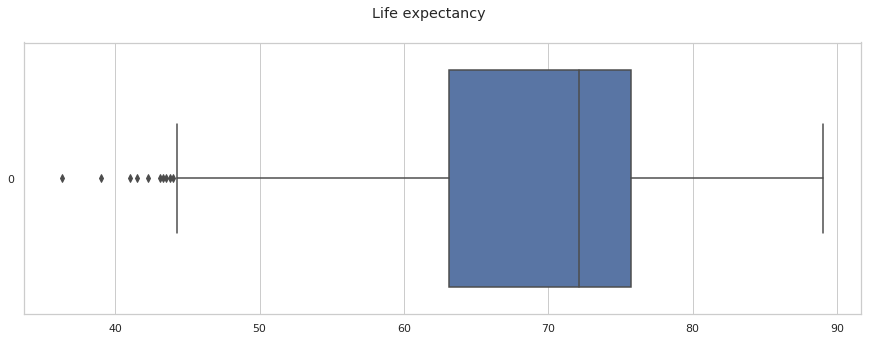

In [768]:
quick_boxplot(life_df['Life expectancy'],'Life expectancy',logscale=False)

In [769]:
life_df.loc[life_df['Life expectancy'] < 40][['Country','Year','Life expectancy']]

Country  Year  Life expectancy
1128         Haiti  2010             36.3
2313  Sierra Leone  2000             39.0

__Basic univariate analyis:__ The distribution is not normal, but it's close:

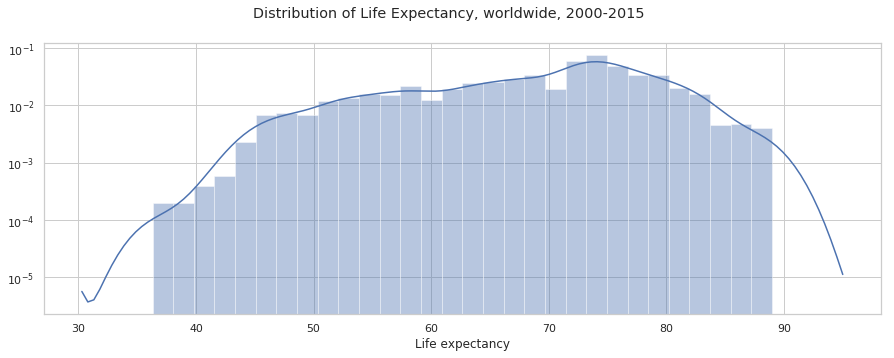

In [770]:
quick_distplot(life_df['Life expectancy'],"Distribution of Life Expectancy, worldwide, 2000-2015")

### Adult mortality

These numbers are mostly reasonable, being the probability of dying between ages 15 and 60, per 1000 population. I'd expect to see numbers 0-1000 and at least that is true. I do see some minor outliers--instances where a country has a really low number for just one year (Afghanistan, 2002; Zimbabwe, 2006, when Zimbabwe has the three highest values in the preceding years 2003-2005).

In [771]:
life_df['Adult mortality'].describe()

count    2928.000000
mean      164.796448
std       124.292079
min         1.000000
25%        74.000000
50%       144.000000
75%       228.000000
max       723.000000
Name: Adult mortality, dtype: float64

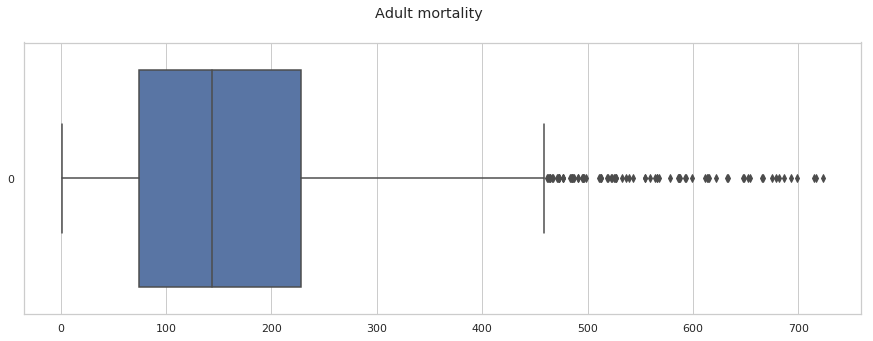

In [772]:
quick_boxplot(life_df['Adult mortality'],"Adult mortality",logscale=False)

We can winsorize these values to reduce the chances of an outlier affecting later analysis. The whiskers of the box are at 1.5 * the standard devation from the 1st and 3rd quartiles. 1s and 0s make basically no sense here, so we can tighten up the low end a little more.

In [773]:
life_df['Adult mortality'] = winsorize(life_df['Adult mortality'], (.15, .05))
#winz_adult_df = pd.DataFrame(data=winz_adult,columns=['Adult mortality'])
#winz_adult_df.describe()

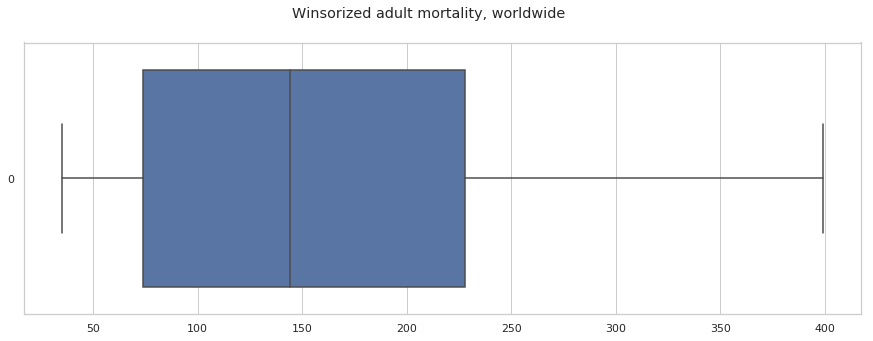

In [774]:
quick_boxplot(life_df['Adult mortality'],"Winsorized adult mortality, worldwide",logscale=False)

In [775]:
life_df['Adult mortality'].describe()

count    2928.000000
mean      162.477459
std       106.759171
min        35.000000
25%        74.000000
50%       144.000000
75%       228.000000
max       399.000000
Name: Adult mortality, dtype: float64

Future work would be to go at this country by country--at the country level, there are still some obvious outliers, like with Afghanistan, for instance:

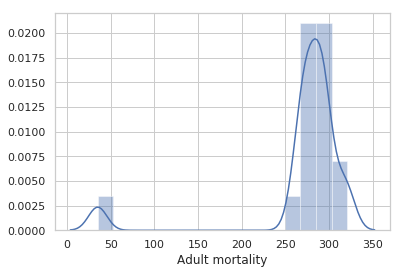

In [776]:
sns.distplot(life_df.loc[life_df['Country'] == 'Afghanistan']['Adult mortality'])

__Basic univariate analysis:__ This distribution skews right somewhat, and the spikes at either end from winsorization throw off the overall shape, but is sort of normal.

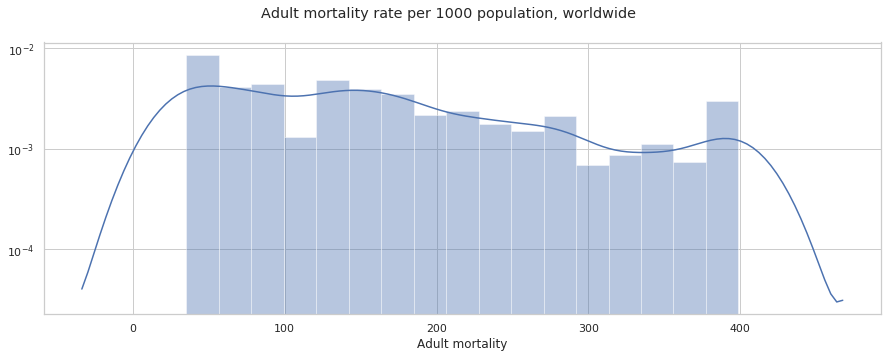

In [777]:
quick_distplot(life_df['Adult mortality'],'Adult mortality rate per 1000 population, worldwide')

## Infant deaths

This is infant deaths per 1000 population. There are a lot of outliers for this variable that are > 1000, and those don't make sense. The worldwide mean on [The World Bank's site]() ranges from 53 in 2000 to 31 in 2015. Each country has its own unique rates, but the overall trend is linear, decreasing over time. 

All of India's values are over 900, with most over 1000. [The World Bank](https://data.worldbank.org/indicator/SP.DYN.IMRT.IN?locations=IN) suggests a range more like 66.7 - 35.3 deaths per 1000 population between 2000 and 2015. We can divide the values in the dataset by 27 to get numbers that are closer to the actual rates. This feels sort of arbitrary, but these outliers are so far away from the rest of the data points that they drag all of the measures of central tendency far from where they would otherwise be.

Other countries have a similar issue with this rate being much higher in this dataset than as recorded elsewhere (primarily the World Bank website), which I referred to often).

There are a lot of countries that have all zeroes, when it would be a miracle if that were true. Some countries have zeroes for half or fewer of their range of years.

In [778]:
life_df.loc[life_df['Country'] == 'India','Infant deaths'] = life_df.loc[life_df['Country'] == 'India','Infant deaths'] / 27

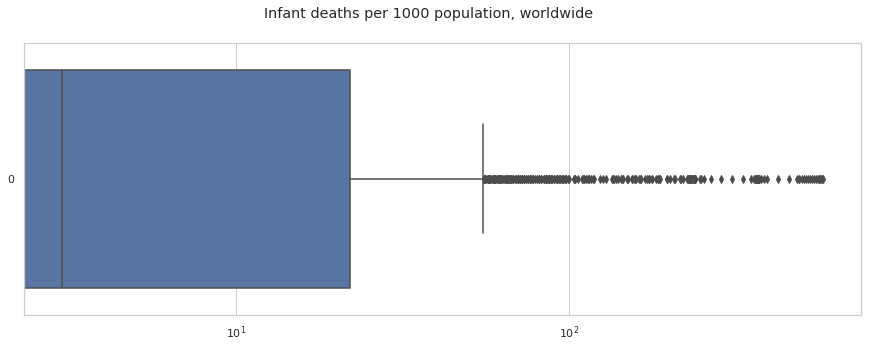

In [779]:
quick_boxplot(life_df['Infant deaths'],"Infant deaths per 1000 population, worldwide")

In [780]:
life_df['Infant deaths'].mean()

23.21580904675167

I get the sense this might be a good place to try log transformation, but I need to do something about the large number of zeroes. Let's try replacing them with the mean for this variable, then see how a distribution of the log of this variable looks.

In [781]:
life_df.loc[life_df['Infant deaths'] == 0,'Infant deaths'] = life_df['Infant deaths'].mean()

In [782]:
np.log(life_df['Infant deaths']).describe()

count    2928.000000
mean        2.499208
std         1.416148
min         0.000000
25%         1.386294
50%         3.144833
75%         3.144833
max         6.356108
Name: Infant deaths, dtype: float64

__Basic univariate analysis:__ I created an artificial spike at the mean by substituting the mean for all of the zeroes present in this column of the dataset, but the log transformation seems to have helped with the number of large outliers. It skews right slightly but is somewhat normal.

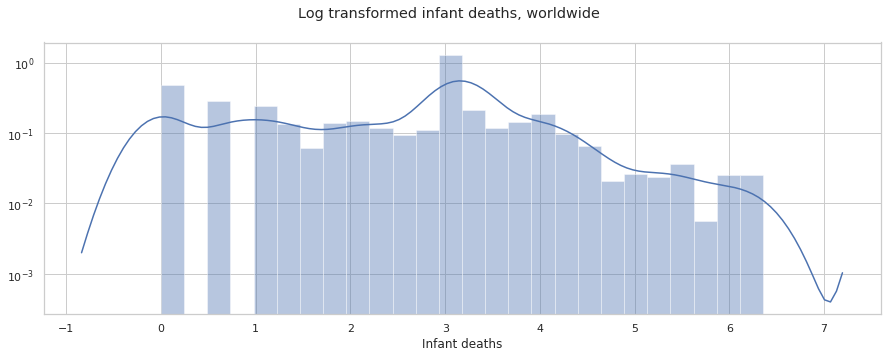

In [783]:
quick_distplot(np.log(life_df['Infant deaths']),"Log transformed infant deaths, worldwide")

In [784]:
life_df['Infant deaths'] = np.log(life_df['Infant deaths'])

## Alcohol consumption

No outliers here. There are a lot of countries with low numbers--at a glance, a lot of them are countries who likely have strict laws against consumption based on religious reasons (Middle Eastern countries for instance). I'm going to roll with these numbers.

In [785]:
life_df.loc[life_df['Alcohol'] < 1]['Country'].unique()

array(['Afghanistan', 'Algeria', 'Azerbaijan', 'Bangladesh', 'Benin',
       'Bhutan', 'Botswana', 'Brunei Darussalam', 'Burkina Faso',
       'Burundi', "Côte d'Ivoire", 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Cyprus',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji',
       'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti',
       'Hungary', 'India', 'Indonesia', 'Iran (Islamic Republic of)',
       'Iraq', 'Japan', 'Jordan', 'Kenya', 'Kiribati', 'Kuwait',
       'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia',
       'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Malaysia',
       'Maldives', 'Mali', 'Mauritania', 'Mauritius', 'Mongolia',
       'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia',
       'Nepal', 'Netherlands', 'Niger', 'Nigeria', 'Oma

__Basic univariate analysis:__ This distribution skews right but is kind of normal?

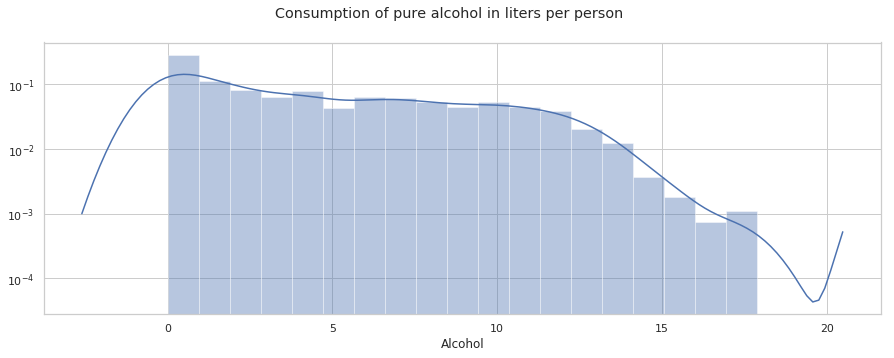

In [786]:
quick_distplot(life_df['Alcohol'],"Consumption of pure alcohol in liters per person")

## Percentage expenditure on health as a percentage of GDP per capita

This number is a percentage--so unless a country is spending exorbitant amounts on health care, a range 0-100% should cover all reasonable values.

There are a number of LARGE outliers here--large enough to make me wonder if they represent actual amounts of money spent on health and not just a percentage of GDP. I'm going to take an educated guess that they are, and where we have values greater than 100, I'm going to use the values we have for GDP to transform these values into proper percentages ("percentage" expenditure, divided by GDP, times 100).

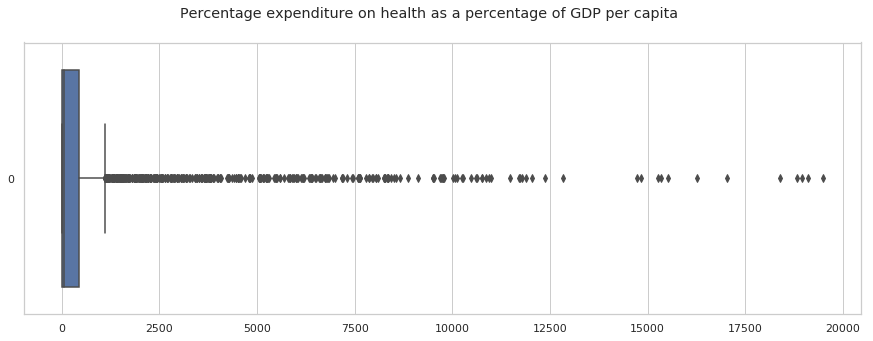

In [787]:
quick_boxplot(life_df['Percentage expenditure'],"Percentage expenditure on health as a percentage of GDP per capita",logscale=False)

In [788]:
life_df['Percentage expenditure'].describe()

count     2928.000000
mean       740.321185
std       1990.930605
min          0.000000
25%          4.853964
50%         65.611455
75%        442.614322
max      19479.911610
Name: Percentage expenditure, dtype: float64

In [789]:
life_df.loc[life_df['Percentage expenditure'] > 100,['Country','Percentage expenditure']].groupby('Country').mean()

Percentage expenditure
Country                                       
Albania                             343.565300
Algeria                             332.188356
Angola                              222.553688
Antigua and Barbuda                1143.035762
Argentina                           939.605576
Armenia                             254.318414
Australia                          6090.659742
Austria                            6053.424077
Azerbaijan                          233.132708
Bahrain                             687.816110
Barbados                            475.861166
Belarus                             626.801046
Belgium                            2551.928167
Belize                              440.970231
Benin                               110.263362
Bhutan                              220.585486
Bosnia and Herzegovina              451.735728
Botswana                            477.424597
Brazil                              554.367237
Brunei Darussalam                  1568.715352
Bulgaria                            500.542815
Burkina Faso                        107.798834
Cabo Verde                          268.214419
Cameroon                            100.898745
Canada                             5007.017570
Chile                               942.747610
China                               164.698409
Colombia                            678.871970
Costa Rica                         1187.590846
Croatia                            1423.106773
...                                        ...
Samoa                               427.762176
Sao Tome and Principe               213.195437
Saudi Arabia                        957.185410
Serbia                              609.925578
Seychelles                          667.560019
Singapore                          2488.076543
Slovenia                           1776.444128
Solomon Islands                     234.203279
South Africa                        701.127892
Spain                              2662.849605
Sri Lanka                           146.537227
Sudan                               199.883573
Suriname                            720.674965
Swaziland                           470.689024
Sweden                             4734.040697
Switzerland                       10455.264403
Syrian Arab Republic                119.455464
Thailand                            526.713381
Tonga                               501.898640
Trinidad and Tobago                 794.802768
Tunisia                             442.301499
Turkey                              394.177850
Turkmenistan                        343.570714
Uganda                              116.202964
Ukraine                             317.395560
United Arab Emirates               2012.513696
Uruguay                             823.562452
Uzbekistan                          130.073822
Vanuatu                             368.734582
Zambia                              168.631643

[128 rows x 1 columns]

In [790]:
life_df['Corrected expenditure'] = (life_df.loc[life_df['Percentage expenditure'] > 100,'Percentage expenditure'] / life_df['Gdp']) * 100
life_df['Merged expenditure'] = life_df['Corrected expenditure'].fillna(life_df['Percentage expenditure'])
life_df['Merged expenditure']

0       71.279624
1       73.523582
2       73.219243
3       78.184215
4        7.097109
5       79.679367
6       56.762217
7       25.873925
8       10.910156
9       17.171518
10       1.388648
11      15.296066
12      11.089053
13      16.887351
14      10.574728
15      10.424960
16       9.230000
17       9.370000
18       9.760000
19       9.710000
20       9.850000
21      41.822757
22       8.460000
23      36.622068
24      32.246552
25       3.302154
26      26.993121
27       9.180000
28      14.719289
29       7.190000
          ...    
2908    20.623063
2909    11.350000
2910    11.130000
2911    12.600000
2912    12.630000
2913    11.220000
2914    10.851482
2915     1.860004
2916    17.630000
2917     8.369852
2918    65.789974
2919    54.043480
2920    46.830275
2921    45.616880
2922     0.000000
2923    10.822595
2924    10.666707
2925    92.602336
2926    63.750530
2927    53.308581
2928     1.040021
2929    20.843429
2930    29.814566
2931    34.262169
2932     8

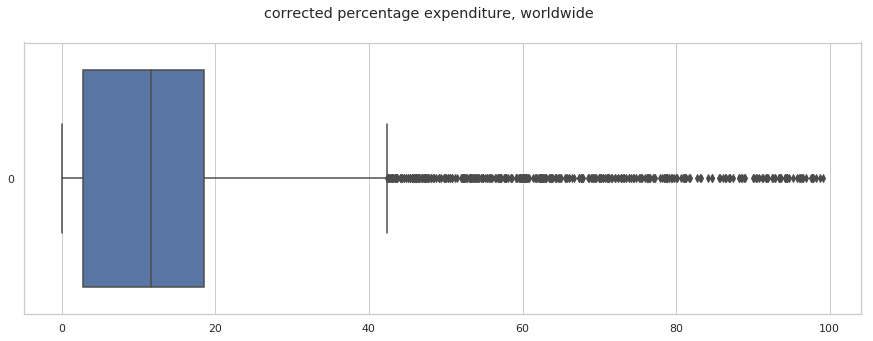

In [791]:
quick_boxplot(life_df['Merged expenditure'],"corrected percentage expenditure, worldwide",logscale=False)

The remaining outliers are not great, even after transforming the largest outliers of the raw data into percentages--98% of GDP per capita expenditure on health is probably not reasonable.

There are also a lot of zeroes here--Zimbabwe, for instance, does not spend a lot [based on what I see on the WHO website](https://www.who.int/countries/zwe/en/), but they spend more than 0% of GDP per capita. We'll have to address these as well.

We can try winsorizing to a minimum of 4% - 5%, and a max of, say, 50% (still unreasonable but less so?), and see how that looks.

In [792]:
life_df['Merged expenditure'] = winsorize(life_df['Merged expenditure'], (.2, .085))
life_df['Merged expenditure'].describe()

count    2928.000000
mean       15.860992
std        16.880936
min         0.000000
25%         2.717652
50%        11.575000
75%        18.582500
max        55.831076
Name: Merged expenditure, dtype: float64

__Basic univariate analysis:__ Except for the spikes at the end from winsorization, this distribution is skewed right, as was the distribution of the untouched data.

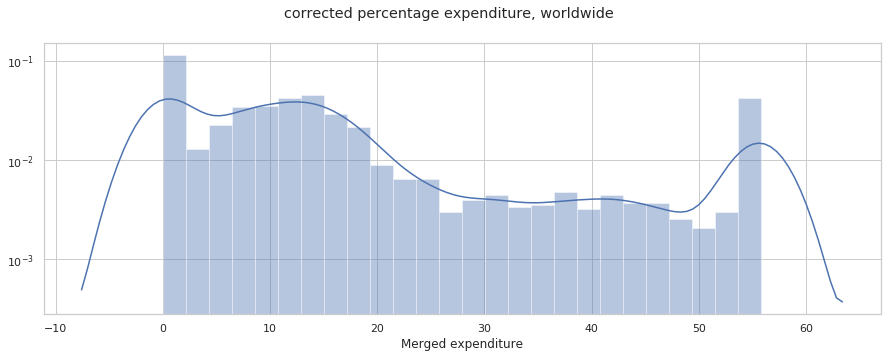

In [793]:
quick_distplot(life_df['Merged expenditure'],"corrected percentage expenditure, worldwide")

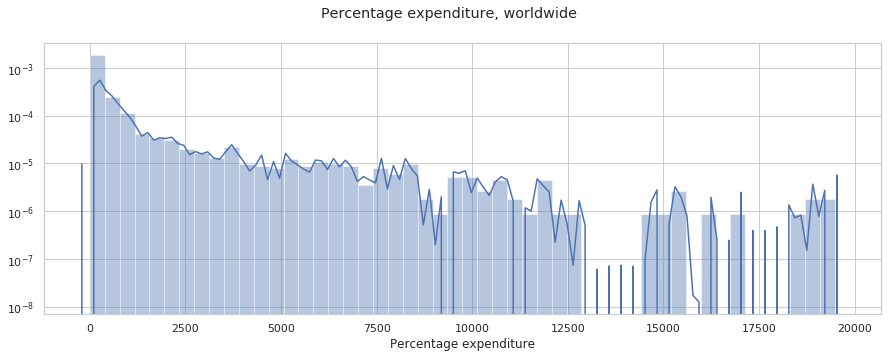

In [794]:
quick_distplot(life_df['Percentage expenditure'],"Percentage expenditure, worldwide")

## Hepatitis B immunization rates for 1-year olds

I dealt with this variable when I found values to fill in above. It is also a percentage, and the outliers here make sense--I assigned Japan its zeroes for instance, because they did not even have a program for immunization against Hepatitis B until 2016.

In [795]:
life_df['Hepatitis b'].describe()

count    2928.000000
mean       75.436014
std        28.612169
min         0.000000
25%        66.000000
50%        88.000000
75%        96.000000
max        99.000000
Name: Hepatitis b, dtype: float64

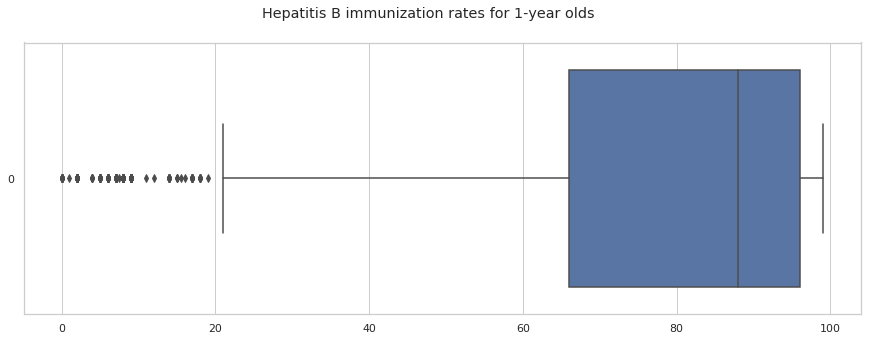

In [796]:
quick_boxplot(life_df['Hepatitis b'],"Hepatitis B immunization rates for 1-year olds",logscale=False)

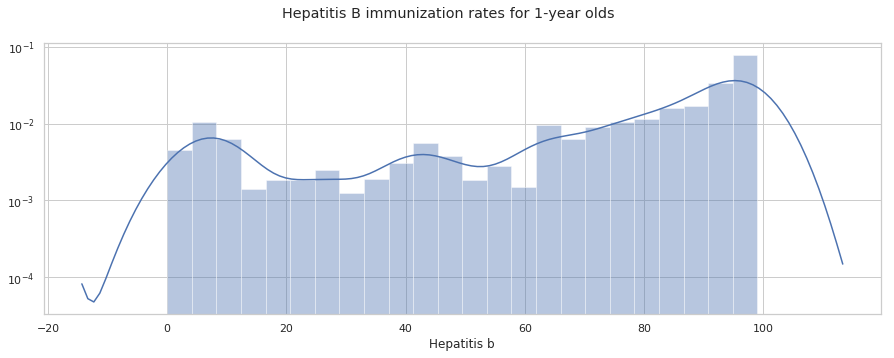

In [797]:
quick_distplot(life_df['Hepatitis b'],"Hepatitis B immunization rates for 1-year olds")

## Population

I filled in a lot of missing values for this category. The other thing I noticed that is wrong here is that the population for some countries fluctuates wildly over the 2000-2015 period. It looks like in the cases I spot-checked that the values for some years need to be multiplied by some power of 10 to bring them in line with the actual population totals.

My guess is population is not going to have any strong, direct relationship to life expectancy, but popluation will be handy to have available for some of the following sections, where we are given rates of events per 1000 population. 

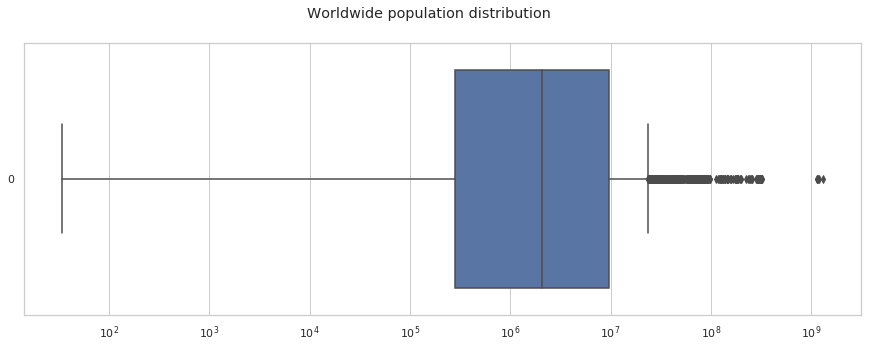

In [798]:
quick_boxplot(life_df['Population'],'Worldwide population distribution')

We can try using logarithmic transformation. (It looks kind of good actually--if we take that bump at the bottom end to represent a bunch of smaller countries. Does that seem reasonable?)

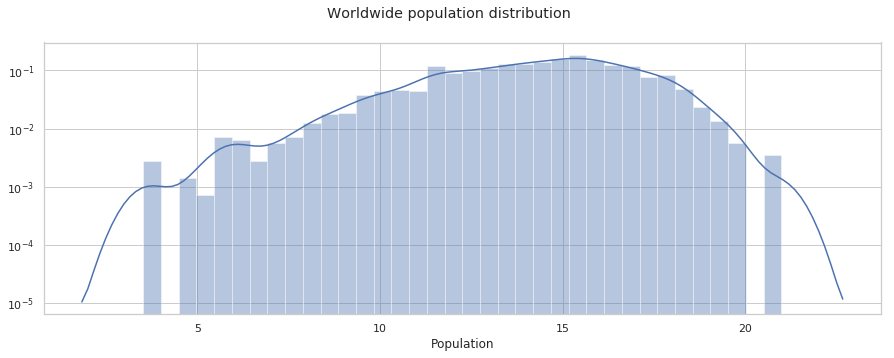

In [799]:
quick_distplot(np.log(life_df['Population']),'Worldwide population distribution')

In [800]:
life_df['Population'] = np.log(life_df['Population'])

__Future work:__ Fix the population outliers for each of the affected countries--there is quite a list.

## Measles

This is the number of cases reported per 1000 population, so at a max, values 0-1000 make sense. I see a lot of outliers here as well unfortunately. As with percent expenditure above, it looks like some of these values are the actual numbers of cases for the country, and not per 1000 population. We can grab all of the values greater than 1000 and try transforming them based on the country's population.

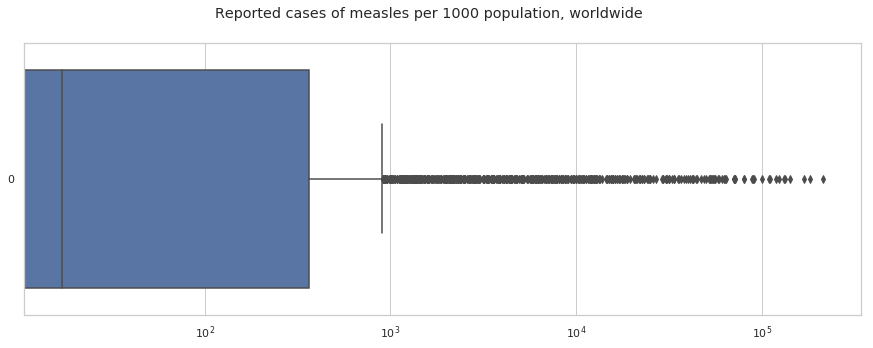

In [801]:
quick_boxplot(life_df['Measles'],"Reported cases of measles per 1000 population, worldwide",logscale=True)

In [802]:
life_df['Measles'].describe()

count      2928.000000
mean       2427.855874
std       11485.970937
min           0.000000
25%           0.000000
50%          17.000000
75%         362.250000
max      212183.000000
Name: Measles, dtype: float64

In [803]:
life_df.loc[life_df['Measles'] > 1000]['Country'].unique()

array(['Afghanistan', "Côte d'Ivoire", 'Algeria', 'Angola', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Benin', 'Bosnia and Herzegovina',
       'Botswana', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Central African Republic', 'Chad', 'China', 'Congo',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Egypt', 'Equatorial Guinea',
       'Ethiopia', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'India', 'Indonesia',
       'Iran (Islamic Republic of)', 'Iraq', 'Italy', 'Japan',
       'Kazakhstan', 'Kenya', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives',
       'Mali', 'Mauritania', 'Mongolia', 'Morocco', 'Mozambique',
       'Myanmar', 'Namibia', 'Nepal', 'Netherlands', 'Niger', 'Nigeria',
       'Pakistan', 'Papua New Guinea', 'Philippines', 'Republic of Korea',
       'R

In [804]:
life_df.loc[life_df['Measles'] > 1000,['Country','Year','Measles']].sort_values(['Measles'],ascending=False)

Country  Year  Measles
1909                                            Nigeria  2000   212183
731                    Democratic Republic of the Congo  2005   182485
1908                                            Nigeria  2001   168107
1906                                            Nigeria  2003   141258
725                    Democratic Republic of the Congo  2011   133802
567                                               China  2008   131441
570                                               China  2005   124219
1576                                             Malawi  2010   118712
1904                                            Nigeria  2005   110927
568                                               China  2007   109023
569                                               China  2006    99602
1187                                              India  2015    90387
574                                               China  2001    88962
723                    Democratic Republic of the Congo  2013    88381
730                    Democratic Republic of the Congo  2006    80123
1188                                              India  2014    79563
724                    Democratic Republic of the Congo  2012    72029
572                                               China  2003    71879
575                                               China  2000    71093
571                                               China  2004    70549
1196                                              India  2006    64185
1889                                              Niger  2004    63057
1567                                         Madagascar  2003    62233
1892                                              Niger  2001    61208
2025                                        Philippines  2014    58848
573                                               China  2002    58341
1193                                              India  2009    56188
729                    Democratic Republic of the Congo  2007    55577
1198                                              India  2004    55443
1890                                              Niger  2003    54190
...                                                 ...   ...      ...
889                                            Ethiopia  2009     1176
2407                                       South Africa  2001     1166
2236                                       Saudi Arabia  2013     1164
2122                                            Romania  2013     1159
1103                                      Guinea-Bissau  2003     1158
469                                            Cambodia  2010     1156
0                                           Afghanistan  2015     1154
2385                                            Somalia  2007     1149
2145                                 Russian Federation  2006     1147
1879                                              Niger  2014     1142
8                                           Afghanistan  2007     1141
1950                                           Pakistan  2008     1129
2876                                           Viet Nam  2013     1123
1582                                             Malawi  2004     1116
2766  United Kingdom of Great Britain and Northern I...  2011     1112
2303                                       Sierra Leone  2010     1089
1789                                            Myanmar  2007     1088
2384                                            Somalia  2008     1081
2164                                             Rwanda  2003     1064
1491                                            Liberia  2015     1060
2406                                       South Africa  2002     1043
1799                                            Namibia  2013     1028
2770  United Kingdom of Great Britain and Northern I...  2007     1022
1845                                        Netherlands  2000     1019
430                                             Burundi  2002     1016
2

In [805]:
life_df['Corrected measles'] = life_df.loc[life_df['Measles'] > 1000,'Measles'] / (life_df['Population'] / 1000)
life_df['Merged measles'] = life_df['Corrected measles'].fillna(life_df['Measles'])
life_df['Merged measles']

0       6.657401e+04
1       4.920000e+02
2       4.300000e+02
3       1.842886e+05
4       2.021203e+05
5       1.337197e+05
6       2.278248e+05
7       1.078976e+05
8       6.673665e+04
9       1.347607e+05
10      1.040134e+05
11      4.660000e+02
12      7.980000e+02
13      1.470515e+05
14      5.879400e+05
15      5.188037e+05
16      0.000000e+00
17      0.000000e+00
18      0.000000e+00
19      9.000000e+00
20      2.800000e+01
21      1.000000e+01
22      0.000000e+00
23      0.000000e+00
24      2.200000e+01
25      6.800000e+01
26      6.000000e+00
27      7.000000e+00
28      8.000000e+00
29      1.600000e+01
            ...     
2908    3.500000e+01
2909    8.960000e+02
2910    8.033605e+05
2911    1.330702e+06
2912    2.600000e+01
2913    1.400000e+02
2914    5.350000e+02
2915    4.590000e+02
2916    4.500000e+01
2917    3.500000e+01
2918    8.810000e+02
2919    2.154649e+06
2920    1.178987e+06
2921    2.171810e+06
2922    0.000000e+00
2923    0.000000e+00
2924    0.000

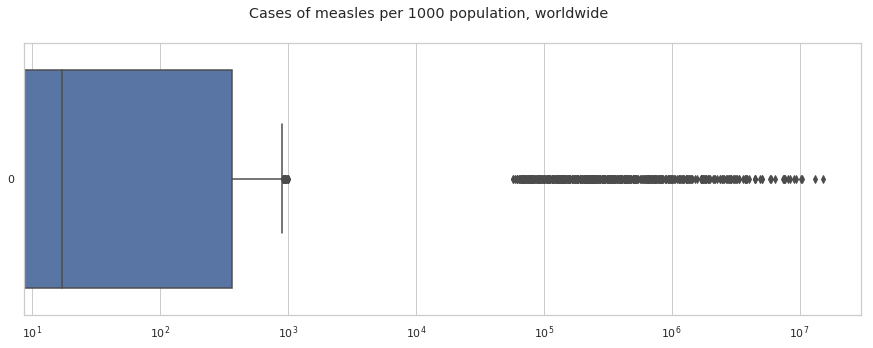

In [806]:
quick_boxplot(life_df['Merged measles'],'Cases of measles per 1000 population, worldwide')

This still has some serious outliers, probably because of garbage data in the Population column. Let's winsorize what we have here and move on.

In [807]:
life_df.loc[life_df['Merged measles'] > 1000,['Country','Year','Measles']]

Country  Year  Measles
0                            Afghanistan  2015     1154
3                            Afghanistan  2012     2787
4                            Afghanistan  2011     3013
5                            Afghanistan  2010     1989
6                            Afghanistan  2009     2861
7                            Afghanistan  2008     1599
8                            Afghanistan  2007     1141
9                            Afghanistan  2006     1990
10                           Afghanistan  2005     1296
13                           Afghanistan  2002     2486
14                           Afghanistan  2001     8762
15                           Afghanistan  2000     6532
37                         Côte d'Ivoire  2001     5790
43                               Algeria  2005     2302
44                               Algeria  2004     3289
45                               Algeria  2003    15374
46                               Algeria  2002     5862
47                               Algeria  2001     2686
50                                Angola  2014    11699
51                                Angola  2013     8523
52                                Angola  2012     4458
53                                Angola  2011     1449
54                                Angola  2010     1190
55                                Angola  2009     2807
57                                Angola  2007     1014
61                                Angola  2003     1196
62                                Angola  2002    11945
63                                Angola  2001     9046
64                                Angola  2000     2219
107                              Armenia  2005     2281
...                                  ...   ...      ...
2786         United Republic of Tanzania  2007     7726
2787         United Republic of Tanzania  2006     2362
2789         United Republic of Tanzania  2004     1419
2790         United Republic of Tanzania  2003     1673
2791         United Republic of Tanzania  2002     5131
2792         United Republic of Tanzania  2001    11847
2793         United Republic of Tanzania  2000    14649
2871  Venezuela (Bolivarian Republic of)  2002     2392
2875                            Viet Nam  2014    15033
2876                            Viet Nam  2013     1123
2879                            Viet Nam  2010     2809
2880                            Viet Nam  2009     6582
2883                            Viet Nam  2006     1978
2886                            Viet Nam  2003     2297
2887                            Viet Nam  2002     6755
2888                            Viet Nam  2001    12058
2889                            Viet Nam  2000    16512
2893                               Yemen  2012     2177
2894                               Yemen  2011     2676
2899                               Yemen  2006     8079
2900                               Yemen  2005     6285
2901                               Yemen  2004    12708
2902                               Yemen  2003     8536
2910                              Zambia  2011    13234
2911                              Zambia  2010    15754
2919                              Zambia  2002    25036
2920                              Zambia  2001    16997
2921                              Zambia  2000    30930
2927                            Zimbabwe  2010     9696
2937                            Zimbabwe  2000     1483

[525 rows x 3 columns]

In [808]:
life_df['Merged measles'] = winsorize(life_df['Merged measles'], (0.35, 0.25))
#winz_measles_df = pd.DataFrame(data=winz_measles,columns=['Merged measles'])
#winz_measles_df.describe()
life_df['Merged measles'].describe()

count    2928.000000
mean      119.956626
std       154.232884
min         1.000000
25%         1.000000
50%        17.000000
75%       362.000000
max       362.000000
Name: Merged measles, dtype: float64

__Basic univariate analysis:__ This variable has so many large outliers, and zeroes, that there are big spikes at both ends of the distribution curve. It skews right overall and it's possible that with better data this would represent a Pareto or exponential distribution...?

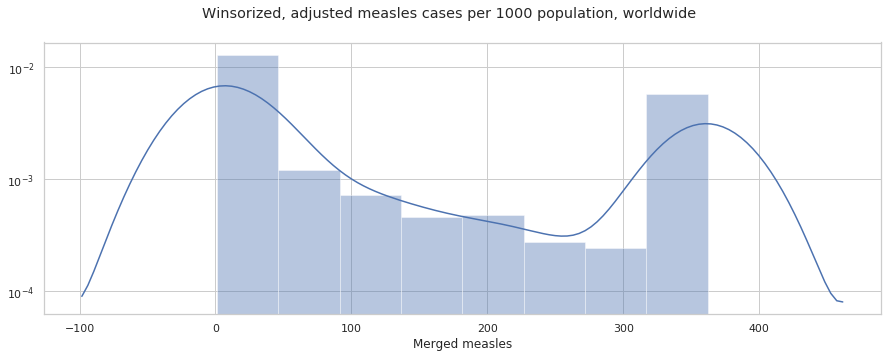

In [809]:
quick_distplot(life_df['Merged measles'],'Winsorized, adjusted measles cases per 1000 population, worldwide')

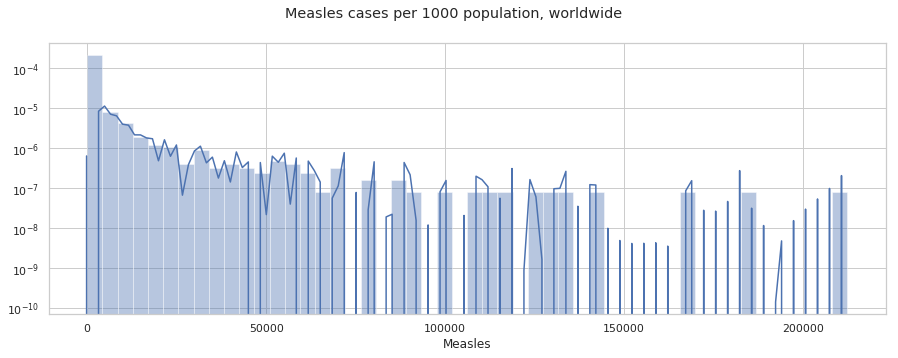

In [810]:
quick_distplot(life_df['Measles'],'Measles cases per 1000 population, worldwide')

## BMI

Average BMI of an entire country's population. Values under 15 or over 50 are probably outliers (this is already a pretty broad range for BMI, which should be in the 20s on average).

[WHO data from 2015 (as reported on this Wikipedia page)](https://en.wikipedia.org/wiki/List_of_countries_by_body_mass_index) suggests the country with the highest overall mean BMI should be Nauru, with 32.5. Samoa should rank third with 31.7. Samoa's values in this dataset are over twice this number.

BMI values for the US are well over twice what they should be, with two outlying values that are 10 times less than the other values.

The distribution is close to normal though, so maybe we leave this as-is for now.

In [811]:
life_df['Bmi'].describe()

count    2928.000000
mean       38.009136
std        19.969835
min         1.000000
25%        19.100000
50%        43.000000
75%        56.100000
max        77.600000
Name: Bmi, dtype: float64

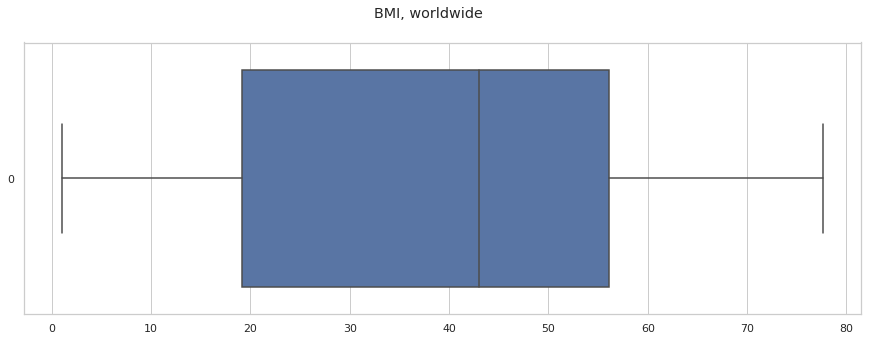

In [812]:
quick_boxplot(life_df['Bmi'],"BMI, worldwide",logscale=False)

__Basic univariate analysis:__ The values are twice what they should be, but the curve is almost normal...so let's see how further analysis looks with the data as-is.

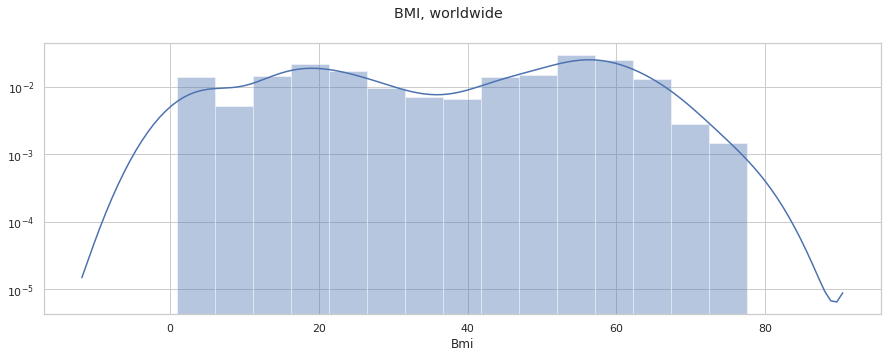

In [813]:
quick_distplot(life_df['Bmi'],"BMI, worldwide")

## Under-five deaths

This stat should be represented as number of deaths per 1000 population. 

The outliers are India's entries in this list, which are clearly garbage--starting with 2500 in the year 2000, and decreasing by 100 each year. We can replace these with the global mean where values are < 1000.

There are some additional outliers, under 1000 but still very high. We can winsorize these.

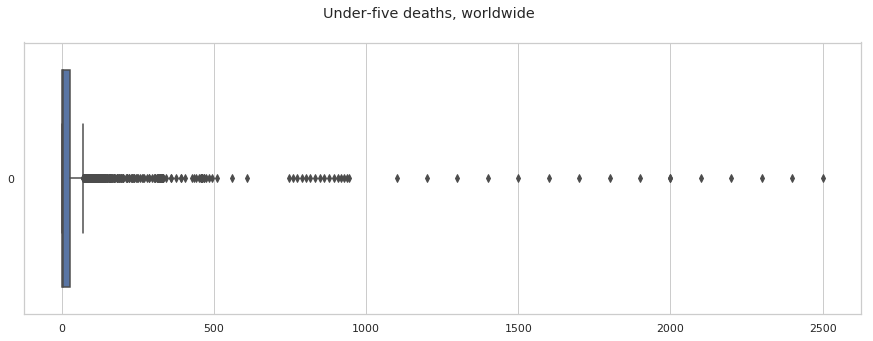

In [814]:
quick_boxplot(life_df['Under-five deaths'],"Under-five deaths, worldwide",logscale=False)

In [815]:
under_five_mean = life_df.loc[life_df['Under-five deaths'] < 1000,['Under-five deaths']].mean()
under_five_mean

Under-five deaths    32.452266
dtype: float64

In [816]:
life_df.loc[life_df['Under-five deaths'] > 1000,['Country','Year','Under-five deaths']]

Country  Year  Under-five deaths
1187   India  2015               1100
1188   India  2014               1200
1189   India  2013               1300
1190   India  2012               1400
1191   India  2011               1500
1192   India  2010               1600
1193   India  2009               1700
1194   India  2008               1800
1195   India  2007               1900
1196   India  2006               2000
1197   India  2005               2000
1198   India  2004               2100
1199   India  2003               2200
1200   India  2002               2300
1201   India  2001               2400
1202   India  2000               2500

In [817]:
life_df.loc[life_df['Country'] == 'India',['Under-five deaths']] = under_five_mean

In [818]:
life_df['Under-five deaths'].describe()

count    2912.000000
mean       32.452266
std        87.586070
min         0.000000
25%         0.000000
50%         4.000000
75%        27.000000
max       943.000000
Name: Under-five deaths, dtype: float64

Nigeria's entries in this list are responsible for most of the remaining outliers greater than 500. These values are far too high--the actual rates for Nigeria, 2000-2015 are more like 186-107. Assuming the highest rate worldwide isn't much more than 186, this sounds like a good target max value for winsorizing.

In [819]:
life_df.loc[life_df['Under-five deaths'] > 500,['Country','Year','Under-five deaths']]

Country  Year  Under-five deaths
573     China  2002              511.0
574     China  2001              558.0
575     China  2000              608.0
1894  Nigeria  2015              747.0
1895  Nigeria  2014              759.0
1896  Nigeria  2013              773.0
1897  Nigeria  2012              788.0
1898  Nigeria  2011              802.0
1899  Nigeria  2010              817.0
1900  Nigeria  2009              832.0
1901  Nigeria  2008              848.0
1902  Nigeria  2007              863.0
1903  Nigeria  2006              879.0
1904  Nigeria  2005              893.0
1905  Nigeria  2004              907.0
1906  Nigeria  2003              918.0
1907  Nigeria  2002              928.0
1908  Nigeria  2001              936.0
1909  Nigeria  2000              943.0

In [820]:
life_df['Under-five deaths'] = winsorize(life_df['Under-five deaths'], (0, .04))
#winz_underfive_df = pd.DataFrame(data=winz_underfive,columns=['Under-five deaths'])
#winz_underfive_df.describe()

__Basic univariate analysis:__ This distribution skews right and is not normal.

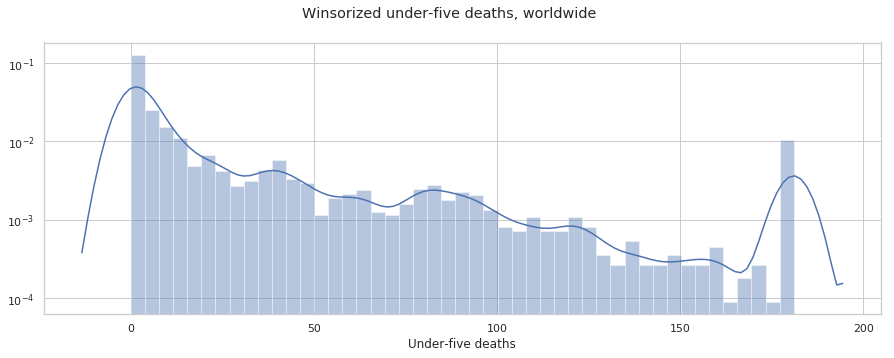

In [821]:
quick_distplot(life_df['Under-five deaths'],'Winsorized under-five deaths, worldwide')

## Polio

Polio immunization coverage among 1-year olds, as a percentage. Valid vales are between 0-100.

There are some low outliers here but this seems mostly reasonable otherwise. [This WHO list of facts about polio](https://www.who.int/features/factfiles/polio/en/) suggests that there are only three countries left who do not vaccinate children against polio: Afghanistan, Pakistan, and Nigeria.

The data has a lot of outliers below the 1st quartile, including some data points for countries like the US. This may be because of the way vaccines are administered (the final dose out of four total for a child in the US is not given until age 4-6, for instance).

We can winsorize these low-end values.

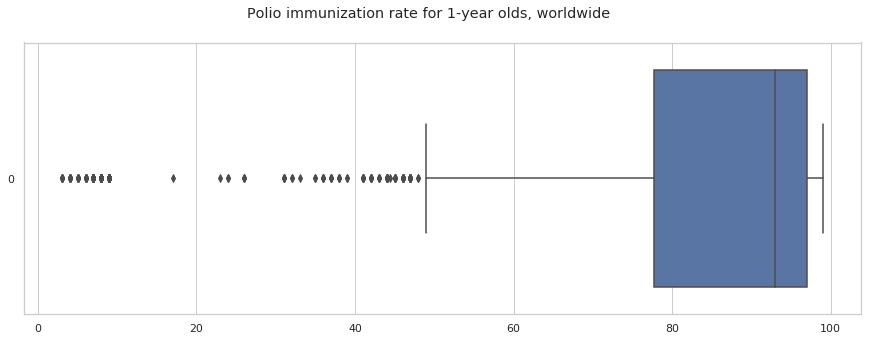

In [822]:
quick_boxplot(life_df['Polio'],"Polio immunization rate for 1-year olds, worldwide",logscale=False)

In [823]:
life_df.loc[life_df['Polio'] < 40,['Country','Polio']].groupby('Country').mean()

Polio
Country                                      
Afghanistan                         21.200000
Angola                              18.571429
Armenia                              9.000000
Australia                            9.000000
Azerbaijan                           8.000000
Bangladesh                           9.000000
Barbados                             9.000000
Belarus                              9.000000
Benin                                8.000000
Bhutan                               9.000000
Bolivia (Plurinational State of)     9.000000
Bosnia and Herzegovina               9.000000
Burkina Faso                         9.000000
Cabo Verde                           9.000000
Cambodia                             8.000000
Cameroon                             8.000000
Canada                               9.000000
Central African Republic            21.666667
Chad                                24.100000
Chile                                9.000000
Colombia                             9.000000
Comoros                              7.333333
Congo                               17.000000
Costa Rica                           8.500000
Côte d'Ivoire                        7.000000
Democratic Republic of the Congo     4.333333
Denmark                              9.000000
Dominican Republic                   9.000000
Ecuador                              9.000000
El Salvador                          9.000000
...                                       ...
Papua New Guinea                     8.000000
Paraguay                             8.500000
Peru                                 9.000000
Philippines                          9.000000
Republic of Korea                    9.000000
Rwanda                               9.000000
Saint Lucia                          8.000000
Samoa                               23.000000
Sao Tome and Principe                9.000000
Senegal                              6.000000
Sierra Leone                        38.000000
Solomon Islands                      9.000000
Somalia                             16.666667
South Africa                         7.000000
South Sudan                          5.000000
Sudan                                7.500000
Suriname                             7.000000
Syrian Arab Republic                 5.333333
Timor-Leste                         22.500000
Togo                                 8.000000
Tonga                                8.500000
Trinidad and Tobago                  9.000000
Turkey                               9.000000
Uganda                               7.000000
United Republic of Tanzania          9.000000
United States of America             9.000000
Venezuela (Bolivarian Republic of)   8.000000
Yemen                                8.000000
Zambia                               8.250000
Zimbabwe                             7.000000

[96 rows x 1 columns]

In [824]:
life_df['Polio'] = winsorize(life_df['Polio'], (0.1, 0))
#winz_polio_df = pd.DataFrame(data=winz_polio,columns=['Polio'])
#winz_polio_df.describe()

__Basic univariate analysis:__ This curve skews left and is not normal.

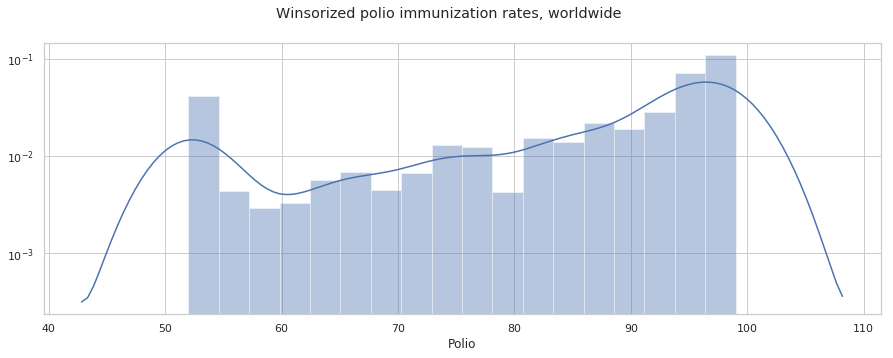

In [825]:
quick_distplot(life_df['Polio'],"Winsorized polio immunization rates, worldwide")

## Total expenditure

General government expenditure on health as a percentage of total government expenditure. 

The outliers here are not very high--still under 20%. [US spending on health care really is as high as these numbers suggest](https://www.cms.gov/research-statistics-data-and-systems/statistics-trends-and-reports/nationalhealthexpenddata/nationalhealthaccountshistorical.html):

> U.S. health care spending grew 3.9 percent in 2017, reaching \\$3.5 trillion or \\$10,739 per person.  As a share of the nation's Gross Domestic Product, health spending accounted for 17.9 percent.

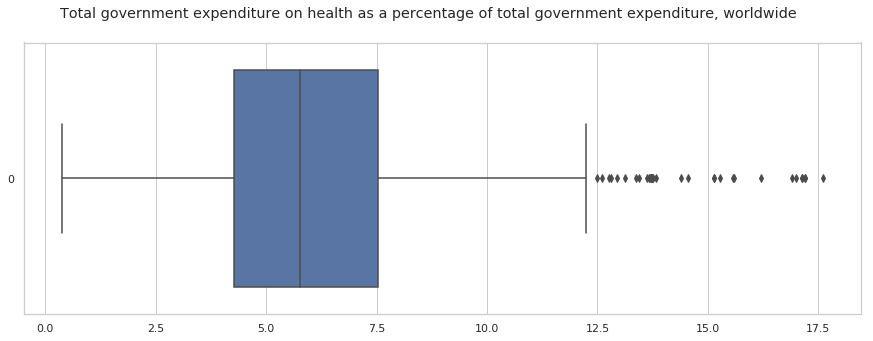

In [826]:
quick_boxplot(life_df['Total expenditure'],"Total government expenditure on health as a percentage of total government expenditure, worldwide",logscale=False)

In [827]:
life_df.loc[life_df['Total expenditure'] > 12.5,['Country','Year','Total expenditure']]

Country  Year  Total expenditure
1387                          Kiribati  2007              13.66
1497                           Liberia  2009              14.39
1574                            Malawi  2012              12.60
1603                          Maldives  2015              13.73
1604                          Maldives  2014              13.73
1700  Micronesia (Federated States of)  2015              13.71
1701  Micronesia (Federated States of)  2014              13.71
1702  Micronesia (Federated States of)  2013              13.38
1703  Micronesia (Federated States of)  2012              12.77
1704  Micronesia (Federated States of)  2011              13.76
1705  Micronesia (Federated States of)  2010              13.83
1706  Micronesia (Federated States of)  2009              13.44
1707  Micronesia (Federated States of)  2008              12.94
2109               Republic of Moldova  2010              12.80
2304                      Sierra Leone  2009              13.13
2313                      Sierra Leone  2000              13.63
2794          United States of America  2015              17.14
2795          United States of America  2014              17.14
2796          United States of America  2013              16.90
2797          United States of America  2012              17.20
2798          United States of America  2011              17.60
2799          United States of America  2010              17.20
2800          United States of America  2009              17.00
2801          United States of America  2008              16.20
2802          United States of America  2007              15.57
2803          United States of America  2006              15.27
2804          United States of America  2005              15.15
2805          United States of America  2004              15.14
2806          United States of America  2003              15.60
2807          United States of America  2002              14.55
2808          United States of America  2001              13.73
2809          United States of America  2000              13.70

__Basic univariate analysis:__ Without touching anything, this curve is almost normal. I'm going to leave this data as-is.

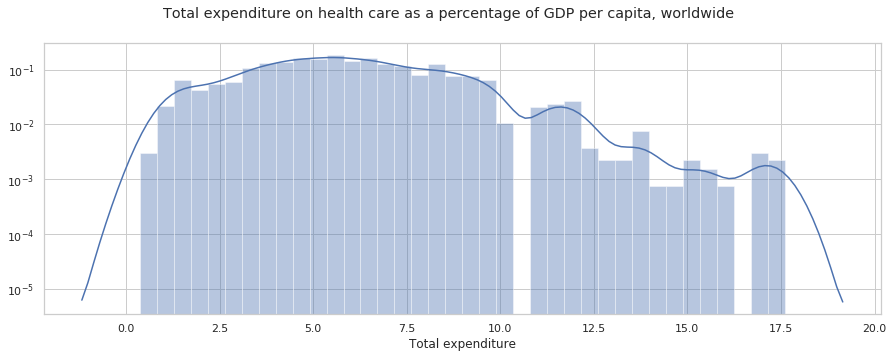

In [828]:
quick_distplot(life_df['Total expenditure'],'Total expenditure on health care as a percentage of GDP per capita, worldwide')

## Diphtheria 

Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds, as a percentage.

Which countries do the low-end outliers represent? Upper limit looks good!

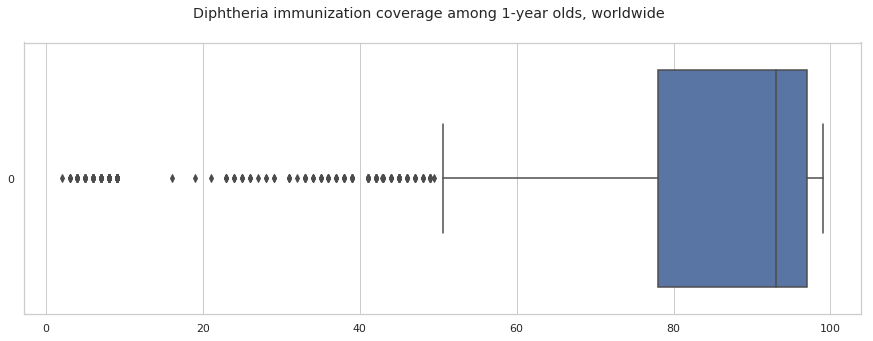

In [829]:
quick_boxplot(life_df['Diphtheria'],"Diphtheria immunization coverage among 1-year olds, worldwide",logscale=False)

There's a lengthy list of outliers at the low end of this distribution:

In [830]:
life_df.loc[life_df['Diphtheria'] < 50,['Country','Diphtheria']].groupby('Country').mean().sort_values('Diphtheria')

Diphtheria
Country                                       
Belarus                               5.000000
Togo                                  5.000000
Venezuela (Bolivarian Republic of)    6.000000
Philippines                           6.000000
Senegal                               6.000000
Madagascar                            6.666667
Indonesia                             7.000000
Cambodia                              7.000000
Zimbabwe                              7.000000
Timor-Leste                           7.000000
India                                 7.000000
Vanuatu                               7.000000
South Africa                          7.000000
Comoros                               7.333333
Benin                                 7.500000
Sudan                                 7.500000
Mauritania                            7.666667
Mozambique                            7.666667
Iraq                                  8.000000
Lebanon                               8.000000
Saint Lucia                           8.000000
Qatar                                 8.000000
Georgia                               8.000000
Uganda                                8.000000
Panama                                8.000000
Gambia                                8.000000
Kiribati                              8.000000
Côte d'Ivoire                         8.000000
Cameroon                              8.000000
Burundi                               8.000000
...                                        ...
Ireland                               9.000000
Israel                                9.000000
Jamaica                               9.000000
Lesotho                               9.000000
Denmark                               9.000000
Democratic Republic of the Congo     14.125000
Ukraine                              15.000000
Guinea                               15.750000
Guinea-Bissau                        21.000000
Congo                                21.166667
Liberia                              22.500000
Syrian Arab Republic                 23.333333
Angola                               24.125000
Ethiopia                             25.750000
Chad                                 26.812500
Burkina Faso                         27.000000
Afghanistan                          27.800000
Haiti                                28.571429
Somalia                              29.312500
Equatorial Guinea                    29.937500
Niger                                35.000000
Nigeria                              35.307692
Gabon                                36.666667
Lao People's Democratic Republic     37.000000
Central African Republic             40.230769
Samoa                                40.750000
Sierra Leone                         41.000000
South Sudan                          42.028571
Mali                                 46.000000
Djibouti                             46.000000

[92 rows x 1 columns]

We can try winsorizing to clean these up.

In [831]:
life_df['Diphtheria'] = winsorize(life_df['Diphtheria'], (0.1, 0))
#winz_diph_df = pd.DataFrame(data=winz_diph,columns=['Polio'])
#winz_diph_df.describe()

__Basic univariate analysis:__ As with the other immunization rate distributions, this distribution skews left and is not normal. 

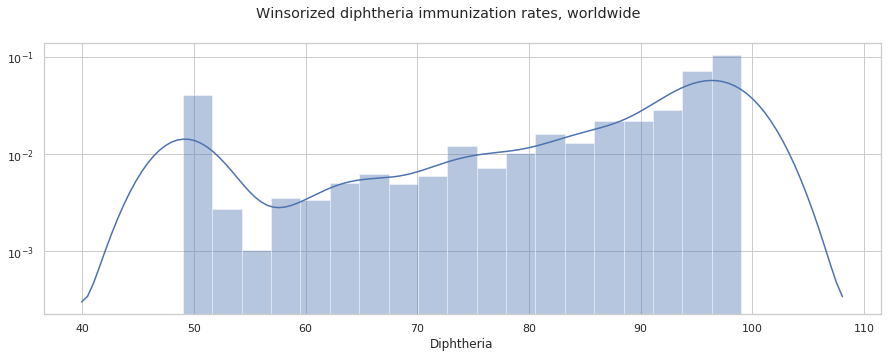

In [832]:
quick_distplot(life_df['Diphtheria'],'Winsorized diphtheria immunization rates, worldwide')

## HIV/AIDS

Deaths per 1000 live births to HIV/AIDS (0-4 years).

I don't know--there are a large number of outliers here, but I think this is because the rate is so low for so many countries that the countries for whom this is a major issue appear to be outliers?

In [833]:
life_df['Hiv/aids'].describe()

count    2928.000000
mean        1.747712
std         5.085542
min         0.100000
25%         0.100000
50%         0.100000
75%         0.800000
max        50.600000
Name: Hiv/aids, dtype: float64

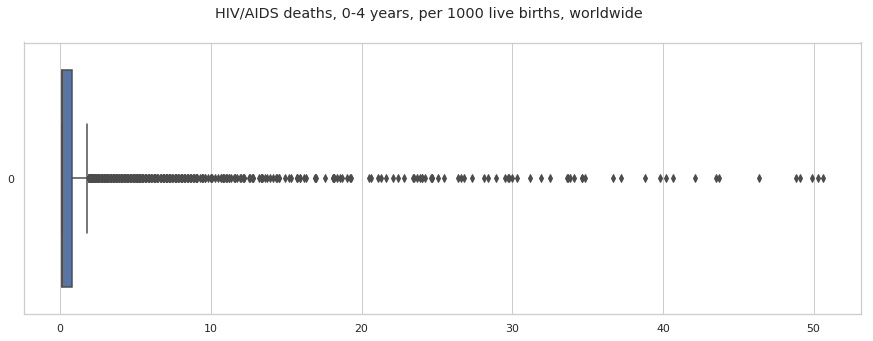

In [834]:
quick_boxplot(life_df['Hiv/aids'],"HIV/AIDS deaths, 0-4 years, per 1000 live births, worldwide",logscale=False)

In [835]:
life_df.loc[life_df['Hiv/aids'] > .8,['Country','Year','Hiv/aids']].sort_values('Hiv/aids',ascending=False)

Country  Year  Hiv/aids
2501              Swaziland  2003      50.6
2500              Swaziland  2004      50.3
2502              Swaziland  2002      49.9
2499              Swaziland  2005      49.1
2503              Swaziland  2001      48.8
2504              Swaziland  2000      46.4
2498              Swaziland  2006      43.7
2937               Zimbabwe  2000      43.5
2936               Zimbabwe  2001      42.1
2497              Swaziland  2007      40.7
2496              Swaziland  2008      40.2
2935               Zimbabwe  2002      39.8
352                Botswana  2000      38.8
351                Botswana  2001      37.2
2934               Zimbabwe  2003      36.7
1485                Lesotho  2005      34.8
350                Botswana  2002      34.6
1486                Lesotho  2004      34.6
1484                Lesotho  2006      34.1
1487                Lesotho  2003      33.8
2495              Swaziland  2009      33.7
2933               Zimbabwe  2004      33.6
1488                Lesotho  2002      32.5
349                Botswana  2003      31.9
1489                Lesotho  2001      31.2
2932               Zimbabwe  2005      30.3
1483                Lesotho  2007      30.0
1490                Lesotho  2000      29.8
2404           South Africa  2004      29.7
2403           South Africa  2005      29.5
...                     ...   ...       ...
2224  Sao Tome and Principe  2009       0.9
856                 Eritrea  2010       0.9
885                Ethiopia  2013       0.9
2476               Suriname  2012       0.9
2225  Sao Tome and Principe  2008       0.9
1652             Mauritania  2015       0.9
1149               Honduras  2005       0.9
2301           Sierra Leone  2012       0.9
775      Dominican Republic  2010       0.9
1492                Liberia  2014       0.9
1653             Mauritania  2014       0.9
2664    Trinidad and Tobago  2000       0.9
1013                  Ghana  2013       0.9
405            Burkina Faso  2011       0.9
2388                Somalia  2004       0.9
472                Cambodia  2007       0.9
460              Cabo Verde  2003       0.9
1883                  Niger  2010       0.9
1491                Liberia  2015       0.9
2390                Somalia  2002       0.9
2389                Somalia  2003       0.9
2387                Somalia  2005       0.9
1014                  Ghana  2012       0.9
2386                Somalia  2006       0.9
2385                Somalia  2007       0.9
2384                Somalia  2008       0.9
2743                Ukraine  2002       0.9
2742                Ukraine  2003       0.9
2740                Ukraine  2005       0.9
224                Barbados  2000       0.9

[711 rows x 3 columns]

__Basic univariate analysis:__ A log transformation makes this distribution almost normal, except for the spike at the low end. It skews slightly to the right, which the original data did as well.

In [836]:
life_df['Hiv/aids log'] = np.log(life_df['Hiv/aids'])

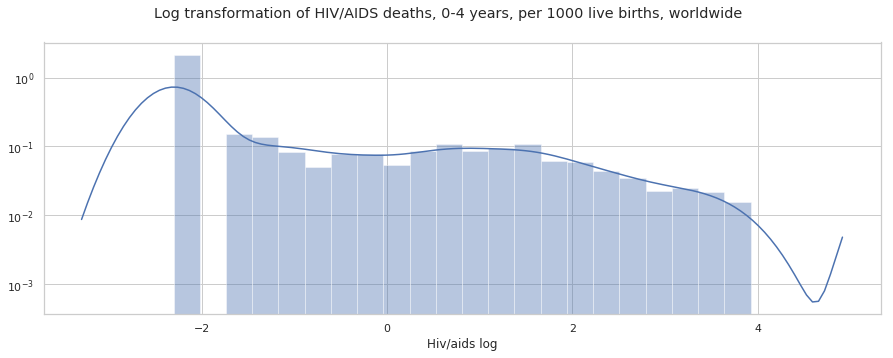

In [837]:
quick_distplot(life_df['Hiv/aids log'],"Log transformation of HIV/AIDS deaths, 0-4 years, per 1000 live births, worldwide")

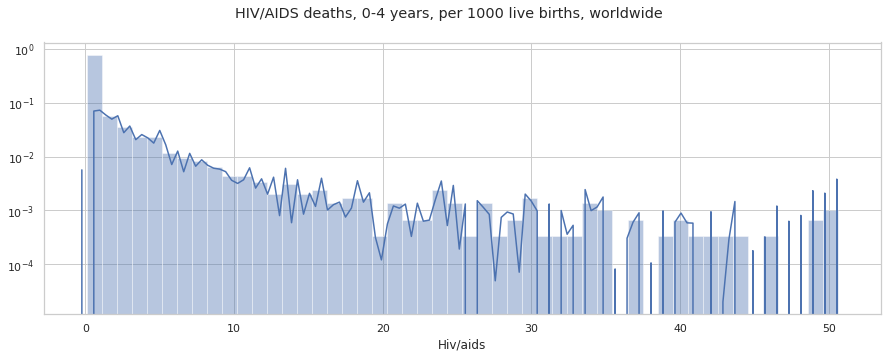

In [838]:
quick_distplot(life_df['Hiv/aids'],"HIV/AIDS deaths, 0-4 years, per 1000 live births, worldwide")

## GDP

Gross Domestic Product per capita (in USD).

Pretty sure the minimum value of 1.68 is too low...[the Wikipedia page about GDP per capita](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita) suggests a minimum of around \\$290 in US dollars, for Burundi.

The outliers at the high end actually seem fine--they represent small but relatively wealthy countries. Luxembourg's GDP really is close to the numbers here, for instance.

In [839]:
life_df['Gdp'].describe()

count      2928.000000
mean       7534.103755
std       13999.610301
min           1.681350
25%         496.568260
50%        1780.431605
75%        6285.631372
max      119172.741800
Name: Gdp, dtype: float64

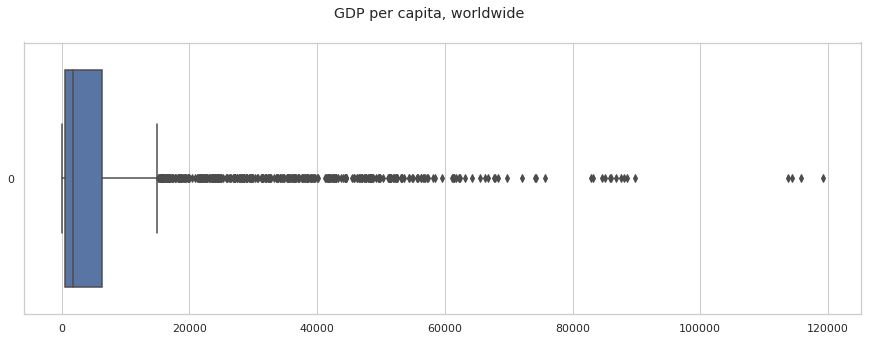

In [840]:
quick_boxplot(life_df['Gdp'],"GDP per capita, worldwide",logscale=False)

In [841]:
life_df.loc[life_df['Gdp'] > 60000,['Country','Year','Gdp']].sort_values('Gdp',ascending=False)

Country  Year           Gdp
1540   Luxembourg  2014  119172.74180
1543   Luxembourg  2011  115761.57700
1546   Luxembourg  2008  114293.84330
1541   Luxembourg  2013  113751.85000
1548   Luxembourg  2006   89739.71170
2075        Qatar  2012   88564.82298
2525  Switzerland  2011   87998.44468
1916       Norway  2010   87646.75346
2073        Qatar  2014   86852.71190
2076        Qatar  2011   85948.74600
2522  Switzerland  2014   85814.58857
1919       Norway  2007   85128.65759
2523  Switzerland  2013   84658.88768
2524  Switzerland  2012   83164.38795
2079        Qatar  2008   82967.37228
1550   Luxembourg  2004   75716.35180
2526  Switzerland  2010   74276.71842
1920       Norway  2006   74114.69715
2528  Switzerland  2008   72119.56870
2527  Switzerland  2009   69672.47100
1179      Iceland  2007   68348.31817
115     Australia  2013   67792.33860
116     Australia  2012   67677.63477
1921       Norway  2005   66775.39440
2072        Qatar  2015   66346.52267
1551   Luxembourg  2003   65445.88530
744       Denmark  2008   64322.66640
2529  Switzerland  2007   63223.46778
738       Denmark  2014   62425.53920
117     Australia  2011   62245.12900
114     Australia  2014   62214.69120
741       Denmark  2011   61753.66700
2078        Qatar  2009   61478.23813
1259      Ireland  2007   61388.17457
1258      Ireland  2008   61235.41500
739       Denmark  2013   61191.19263

__Basic univariate analysis:__ It looks like it may help to perform a log transformation, to tighten up the distribution. Otherwise there is a large gap between Qatar's and Luxembourg's numbers.

The log-transformed distribution curve is almost uniform!

In [842]:
life_df['Gdp log'] = np.log(winsorize(life_df['Gdp'], (0.15, 0)))
#winz_gdp_df = pd.DataFrame(data=winz_gdp,columns=['Polio'])
#winz_gdp_df.describe()

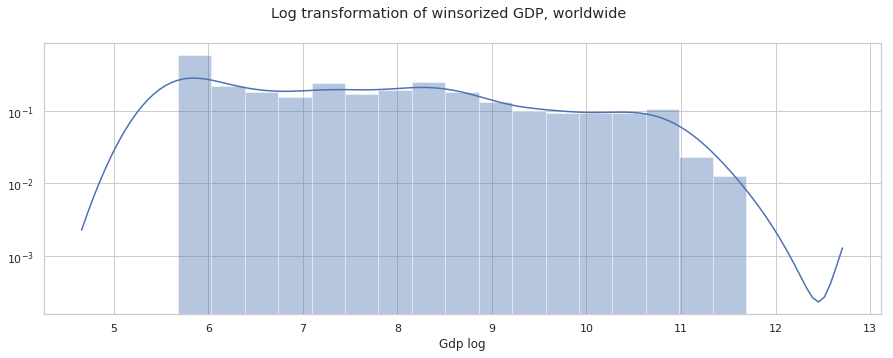

In [844]:
quick_distplot(life_df['Gdp log'],"Log transformation of winsorized GDP, worldwide")

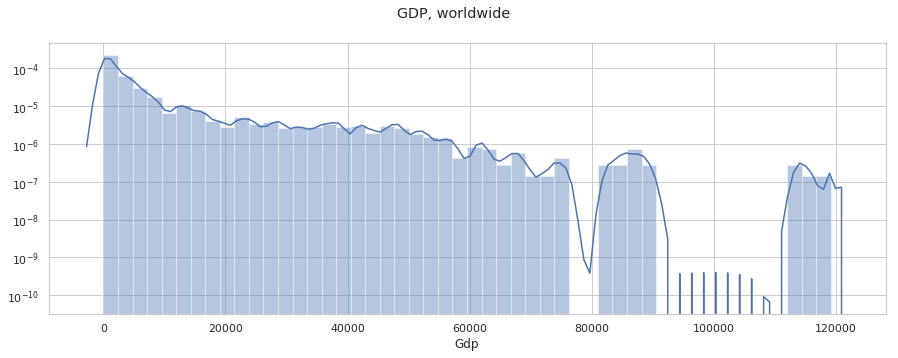

In [845]:
quick_distplot(life_df['Gdp'],"GDP, worldwide")

## Thinness 10-19 years

Prevalence of thinness among children and adolescents for Age 10 to 19, expressed as a percentage.

This seems good at a glance.

In [551]:
life_df['Thinness 1-19 years'].describe()

count    2928.000000
mean        4.883402
std         4.409754
min         0.100000
25%         1.600000
50%         3.400000
75%         7.200000
max        27.700000
Name: Thinness 1-19 years, dtype: float64

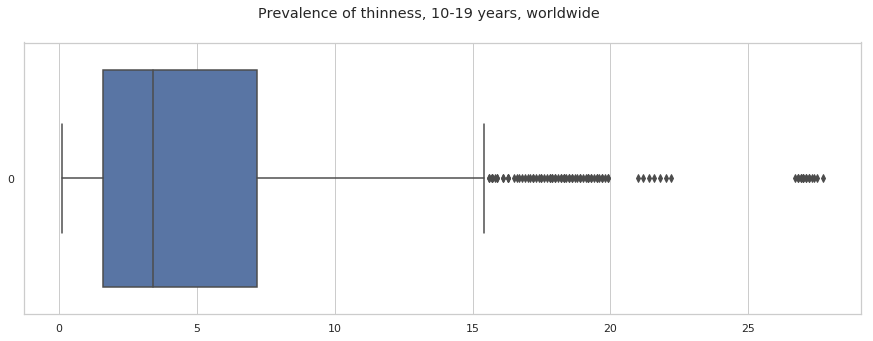

In [552]:
quick_boxplot(life_df['Thinness 1-19 years'],"Prevalence of thinness, 10-19 years, worldwide",logscale=False)

In [553]:
life_df.loc[life_df['Thinness 1-19 years'] > 15,['Country','Thinness 1-19 years']].groupby('Country').mean()

Thinness 1-19 years
Country                          
Afghanistan             18.635714
Bangladesh              18.900000
Bhutan                  17.218750
India                   27.100000
Namibia                 15.450000
Nepal                   17.131250
Pakistan                20.836364
South Africa            15.850000
Sri Lanka               15.325000
Viet Nam                15.500000

__Basic univariate analysis:__ Performing a log transformation on this data yields a nearly normal distribution. 

In [849]:
life_df['Thinness 1-19 years log'] = np.log(life_df['Thinness 1-19 years'])

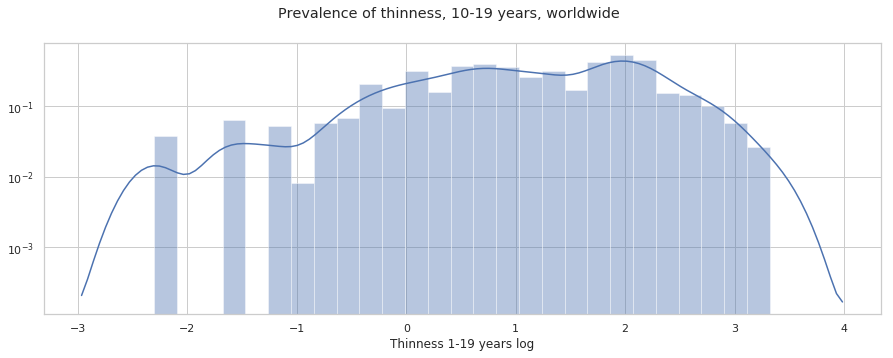

In [850]:
quick_distplot(life_df['Thinness 1-19 years log'],"Prevalence of thinness, 10-19 years, worldwide")

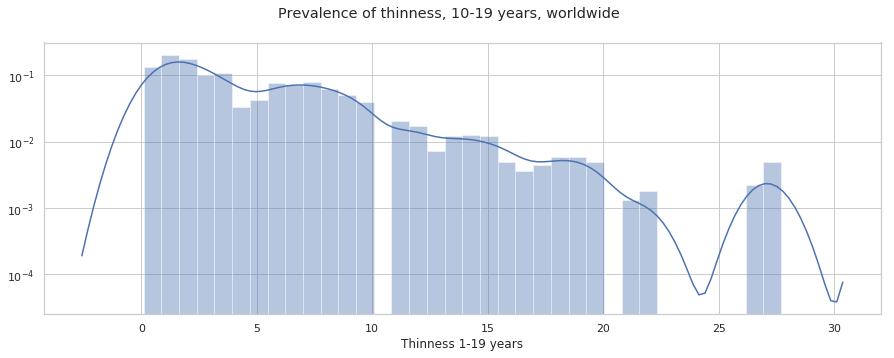

In [851]:
quick_distplot(life_df['Thinness 1-19 years'],"Prevalence of thinness, 10-19 years, worldwide")

## Thinness 5-9 years

Prevalence of thinness among children for Age 5 to 9, expressed as a percentage. These percentages look close to those of the 10-19 group--also a good sign.

In [554]:
life_df['Thinness 5-9 years'].describe()

count    2928.000000
mean        4.907428
std         4.493642
min         0.100000
25%         1.600000
50%         3.400000
75%         7.300000
max        28.600000
Name: Thinness 5-9 years, dtype: float64

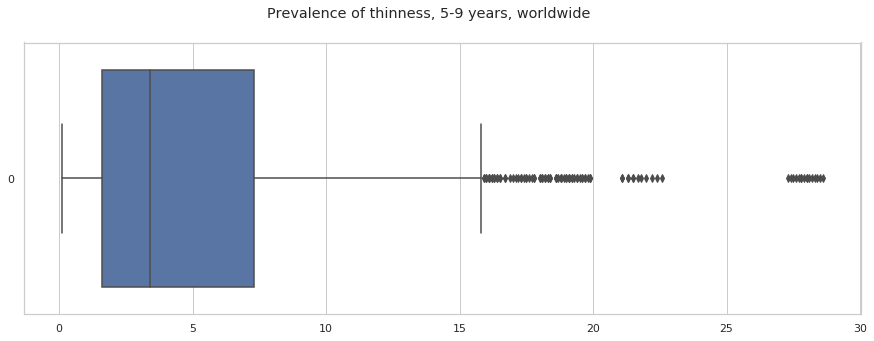

In [555]:
quick_boxplot(life_df['Thinness 5-9 years'],"Prevalence of thinness, 5-9 years, worldwide",logscale=False)

In [556]:
life_df.loc[life_df['Thinness 5-9 years'] > 15,['Country','Thinness 5-9 years']].groupby('Country').mean()

Thinness 5-9 years
Country                         
Afghanistan            18.630769
Bangladesh             19.709091
Bhutan                 17.925000
India                  27.943750
Namibia                15.650000
Nepal                  17.668750
Pakistan               21.454545
South Africa           17.600000
Sri Lanka              15.421429
Viet Nam               15.908333

__Basic univariate analysis:__ As with the other thinness category, the distribution benefits from a log transformation--it becomes nearly normal.

In [853]:
life_df['Thinness 5-9 years log'] = np.log(life_df['Thinness 5-9 years'])

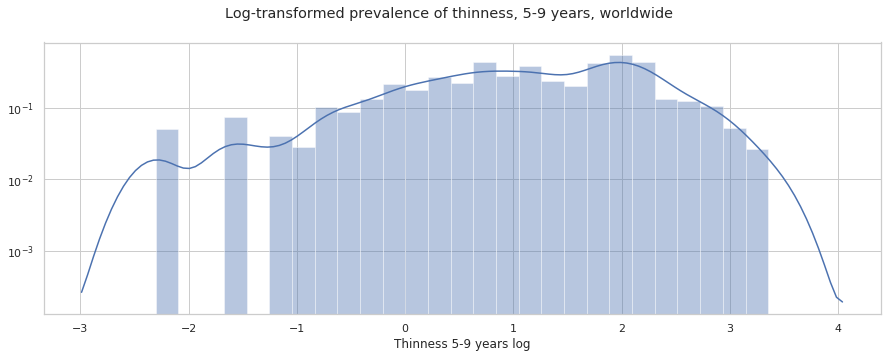

In [854]:
quick_distplot(life_df['Thinness 5-9 years log'],"Log-transformed prevalence of thinness, 5-9 years, worldwide")

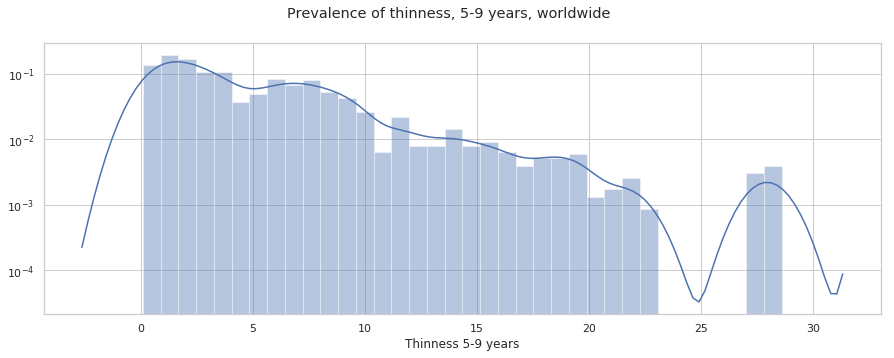

In [852]:
quick_distplot(life_df['Thinness 5-9 years'],"Prevalence of thinness, 5-9 years, worldwide")

## Income composition of resources

Human Development Index in terms of income composition of resources (index ranging from 0 to 1). All of our values fall within this range, so that's a good start.

There are a bunch of zeros for this variable. Many of them appear to be countries who didn't exist in their current form as of the years in question (ex: the former Yugoslavian nations, before 2006). We can try filling in with the mean of the column in these cases.

In [557]:
life_df['Income composition of resources'].describe()

count    2928.000000
mean        0.630953
std         0.211138
min         0.000000
25%         0.492000
50%         0.679000
75%         0.783000
max         0.948000
Name: Income composition of resources, dtype: float64

In [561]:
life_df.loc[life_df['Income composition of resources'] == 0,'Income composition of resources'] = life_df['Income composition of resources'].mean()

__Basic univariate analysis:__ This distribution is almost uniform, but close enough to normal to run with. 

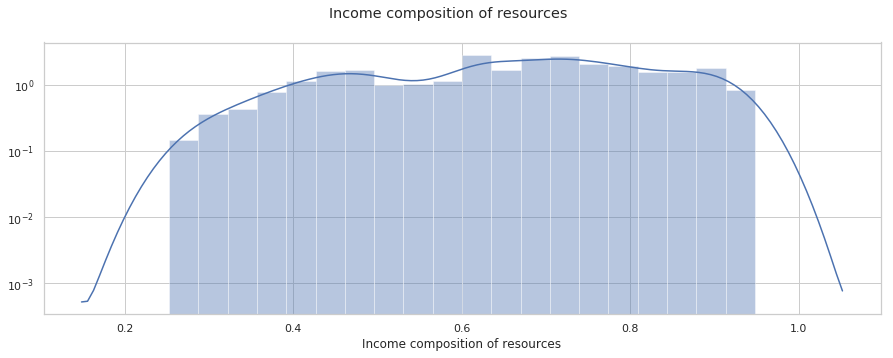

In [566]:
quick_distplot(life_df['Income composition of resources'],"Income composition of resources")

## Schooling

Number of years of Schooling.

These values largely seem okay, but there are some zeroes here. We should at least winsorize those and pull them up to around 5 years.

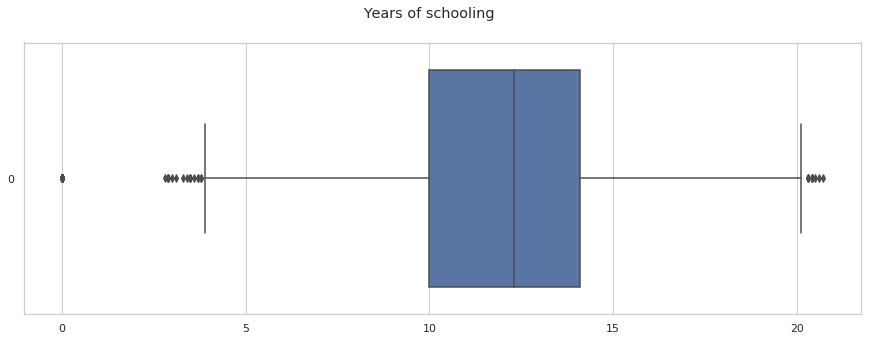

In [567]:
quick_boxplot(life_df['Schooling'],"Years of schooling",logscale=False)

In [568]:
life_df['Schooling'].describe()

count    2928.000000
mean       11.879058
std         3.388684
min         0.000000
25%        10.000000
50%        12.300000
75%        14.100000
max        20.700000
Name: Schooling, dtype: float64

In [569]:
life_df.loc[life_df['Schooling'] < 5,['Country','Year','Schooling']]

Country  Year  Schooling
37             Côte d'Ivoire  2001     4.4442
64                    Angola  2000     4.6000
75       Antigua and Barbuda  2005     0.0000
76       Antigua and Barbuda  2004     0.0000
77       Antigua and Barbuda  2003     0.0000
78       Antigua and Barbuda  2002     0.0000
79       Antigua and Barbuda  2001     0.0000
80       Antigua and Barbuda  2000     0.0000
336   Bosnia and Herzegovina  2000     0.0000
409             Burkina Faso  2007     4.9000
410             Burkina Faso  2006     4.7000
411             Burkina Faso  2005     4.3000
412             Burkina Faso  2004     3.9000
413             Burkina Faso  2003     3.8000
414             Burkina Faso  2002     3.6000
415             Burkina Faso  2001     3.5000
416             Burkina Faso  2000     3.4000
429                  Burundi  2003     4.7000
430                  Burundi  2002     4.4000
431                  Burundi  2001     4.5000
432                  Burundi  2000     4.5000
433            Côte d'Ivoire  2015     4.4442
434            Côte d'Ivoire  2014     4.4442
435            Côte d'Ivoire  2013     4.4442
436            Côte d'Ivoire  2012     4.4442
437            Côte d'Ivoire  2011     4.4442
438            Côte d'Ivoire  2010     4.4442
439            Côte d'Ivoire  2009     4.4442
440            Côte d'Ivoire  2008     4.4442
441            Côte d'Ivoire  2007     4.4442
...                      ...   ...        ...
1882                   Niger  2011     4.8000
1883                   Niger  2010     4.5000
1884                   Niger  2009     4.2000
1885                   Niger  2008     4.0000
1886                   Niger  2007     3.8000
1887                   Niger  2006     3.7000
1888                   Niger  2005     3.5000
1889                   Niger  2004     3.1000
1890                   Niger  2003     3.0000
1891                   Niger  2002     2.9000
1892                   Niger  2001     2.9000
1893                   Niger  2000     2.8000
2409             South Sudan  2015     4.9000
2410             South Sudan  2014     4.9000
2411             South Sudan  2013     4.9000
2412             South Sudan  2012     4.9000
2413             South Sudan  2011     4.9000
2414             South Sudan  2010     0.0000
2415             South Sudan  2009     0.0000
2416             South Sudan  2008     0.0000
2417             South Sudan  2007     0.0000
2418             South Sudan  2006     0.0000
2419             South Sudan  2005     0.0000
2420             South Sudan  2004     0.0000
2421             South Sudan  2003     0.0000
2422             South Sudan  2002     0.0000
2423             South Sudan  2001     0.0000
2424             South Sudan  2000     0.0000
2616             Timor-Leste  2000     0.0000
2712            Turkmenistan  2000     0.0000

[93 rows x 3 columns]

In [191]:
life_df['Schooling'] = winsorize(life_df['Schooling'], (.05, 0))
#winz_school_df = pd.DataFrame(data=winz_school,columns=['Schooling'])
#winz_school_df.describe()

__Basic univariate analysis:__ This is close enough to normal.

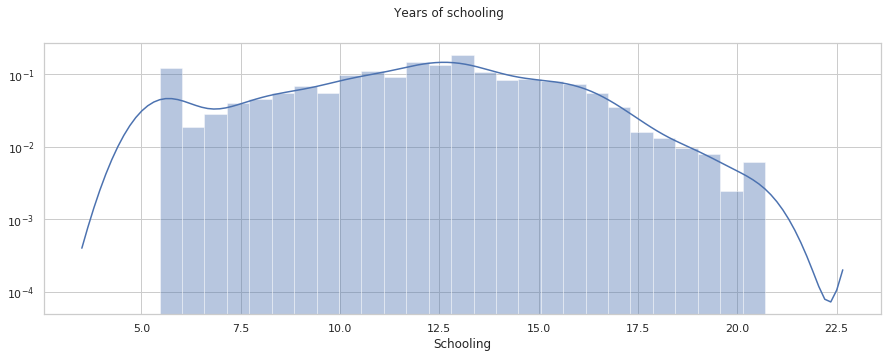

In [192]:
quick_distplot(life_df['Schooling'],'Years of schooling')

## Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

I performed some basic univariate analysis above, as I worked my way through each of the variables. These variables are all continuous data, so substituting the mean for extreme outliers, winsorizing, and log transformations tended to work well to help bring the distributions in line.

In [855]:
# Here's where we are now:
life_df.describe()

Year  Life expectancy  Adult mortality  Infant deaths  \
count  2928.00000      2928.000000      2928.000000    2928.000000   
mean   2007.50000        69.224932       162.477459       2.499208   
std       4.61056         9.523867       106.759171       1.416148   
min    2000.00000        36.300000        35.000000       0.000000   
25%    2003.75000        63.100000        74.000000       1.386294   
50%    2007.50000        72.100000       144.000000       3.144833   
75%    2011.25000        75.700000       228.000000       3.144833   
max    2015.00000        89.000000       399.000000       6.356108   

           Alcohol  Percentage expenditure  Hepatitis b        Measles  \
count  2928.000000             2928.000000  2928.000000    2928.000000   
mean      4.514305              740.321185    75.436014    2427.855874   
std       4.063494             1990.930605    28.612169   11485.970937   
min       0.010000                0.000000     0.000000       0.000000   
25%       0.670000                4.853964    66.000000       0.000000   
50%       3.580000               65.611455    88.000000      17.000000   
75%       7.600000              442.614322    96.000000     362.250000   
max      17.870000            19479.911610    99.000000  212183.000000   

               Bmi  Under-five deaths        Polio  Total expenditure  \
count  2928.000000        2928.000000  2928.000000        2928.000000   
mean     38.009136          25.469945    85.464891           5.971843   
std      19.969835          44.741796    15.347393           2.527820   
min       1.000000           0.000000    52.000000           0.370000   
25%      19.100000           0.000000    77.750000           4.280000   
50%      43.000000           4.000000    93.000000           5.760000   
75%      56.100000          28.000000    97.000000           7.530000   
max      77.600000         181.000000    99.000000          17.600000   

        Diphtheria     Hiv/aids            Gdp   Population  \
count  2928.000000  2928.000000    2928.000000  2928.000000   
mean     85.091803     1.747712    7534.103755    14.229336   
std      16.010366     5.085542   13999.610301     2.618018   
min      49.000000     0.100000       1.681350     3.526361   
25%      78.000000     0.100000     496.568260    12.557864   
50%      93.000000     0.100000    1780.431605    14.540291   
75%      97.000000     0.800000    6285.631372    16.082777   
max      99.000000    50.600000  119172.741800    20.980895   

       Thinness 1-19 years  Thinness 5-9 years  \
count          2928.000000         2928.000000   
mean              4.883402            4.907428   
std               4.409754            4.493642   
min               0.100000            0.100000   
25%               1.600000            1.600000   
50%               3.400000            3.400000   
75%               7.200000            7.300000   
max              27.700000           28.600000   

       Income composition of resources    Schooling  Corrected expenditure  \
count                      2928.000000  2928.000000            1301.000000   
mean                          0.630953    11.879058              11.871314   
std                           0.211138     3.388684               4.871454   
min                           0.000000     0.000000               1.120000   
25%                           0.492000    10.000000               8.530000   
50%                           0.679000    12.300000              12.270000   
75%                           0.783000    14.100000              14.960000   
max                           0.948000    20.700000              34.410000   

       Merged expenditure  Corrected measles  Merged measles  Hiv/aids log  \
count         2928.000000       5.250000e+02     2928.000000   2928.000000   
mean            15.860992       8.797733e+05      119.956626     -1.218259   
std             16.880936       1.703512e+06      154.232884      1.614891   
min              0.0000

### Multivariate analysis

Here are scatterplots of all of the relevant variables plotted against life expectancy.

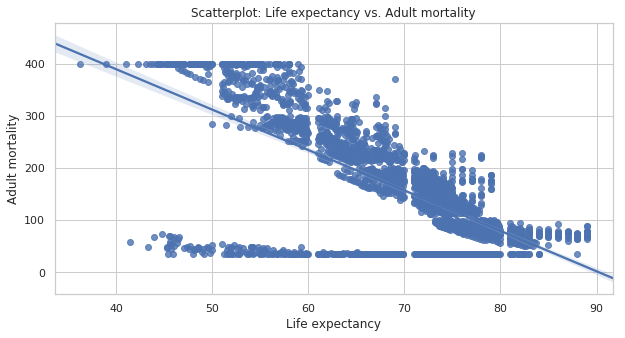

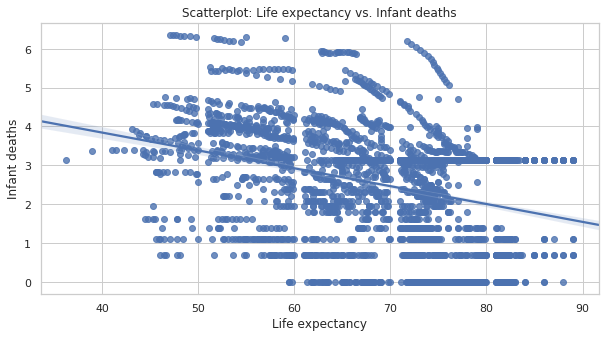

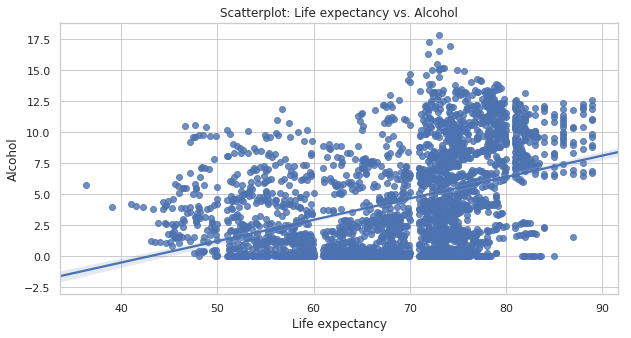

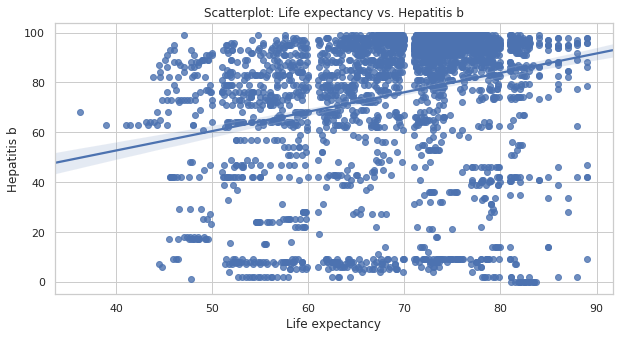

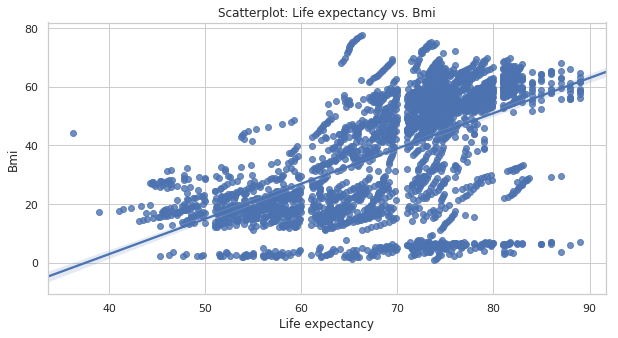

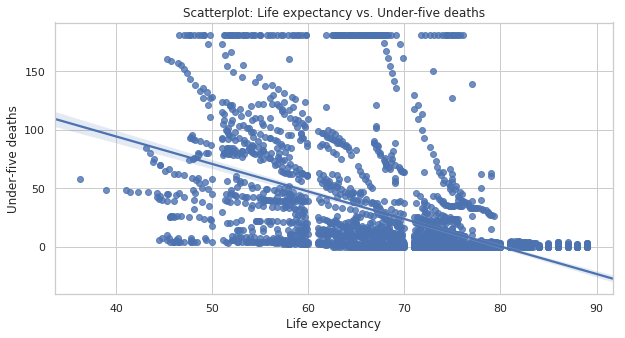

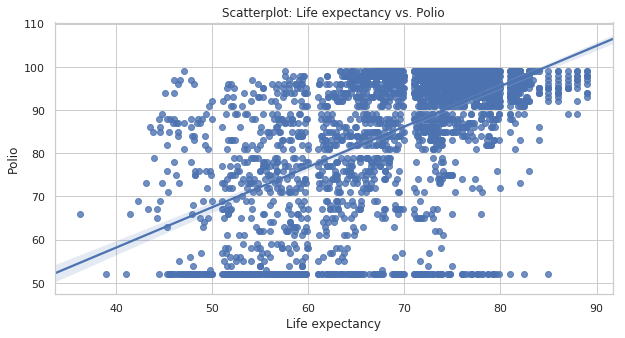

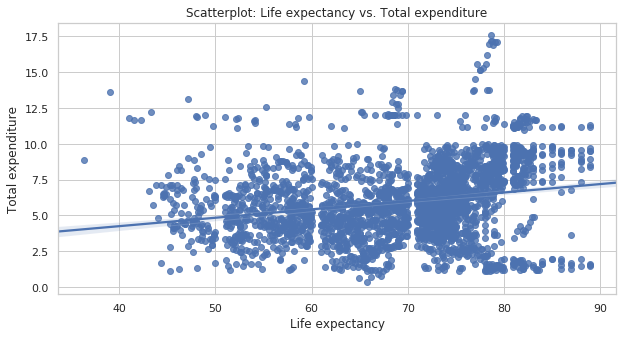

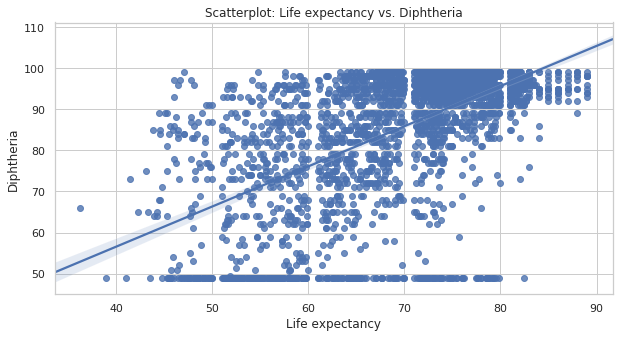

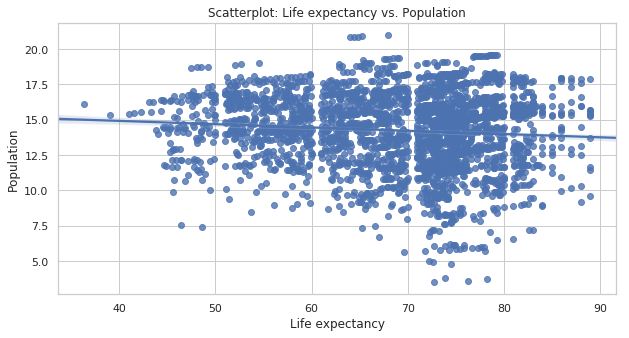

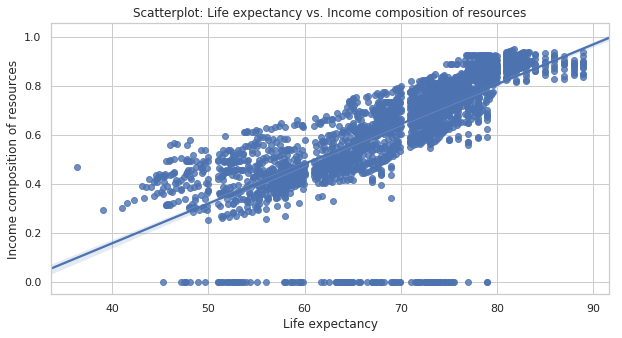

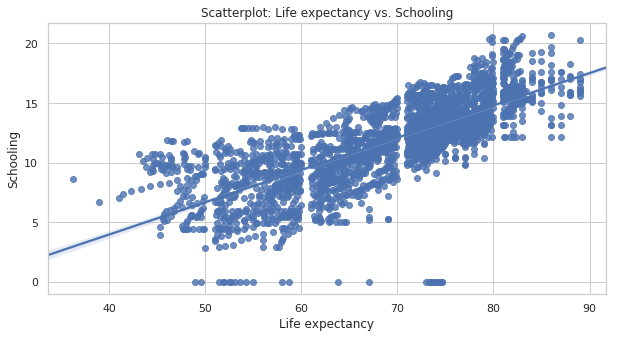

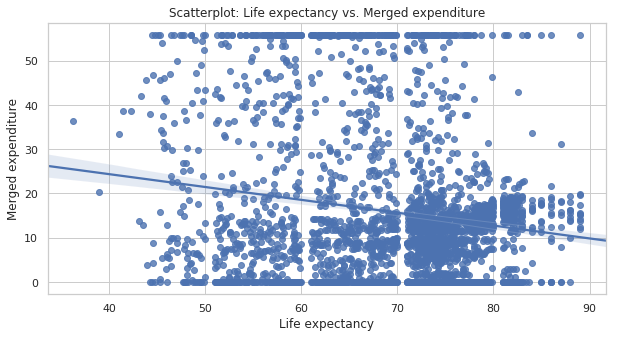

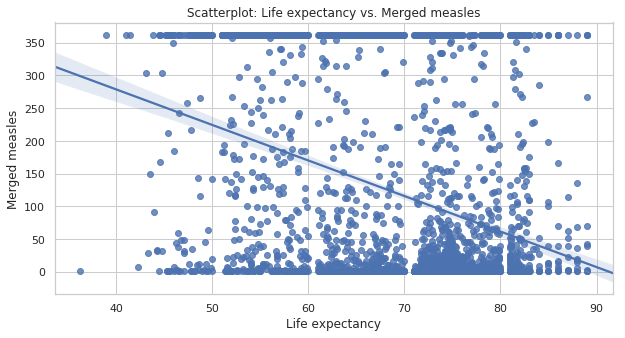

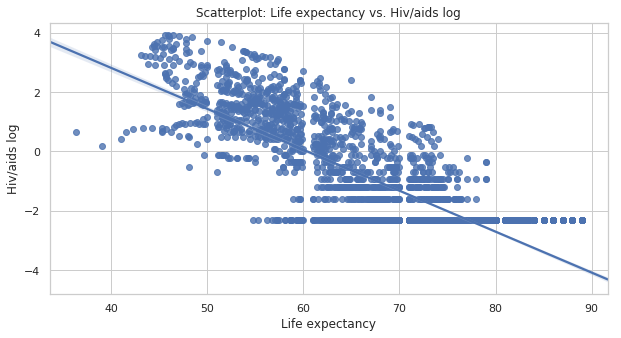

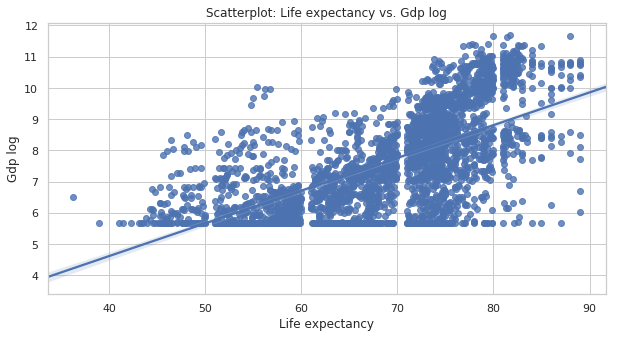

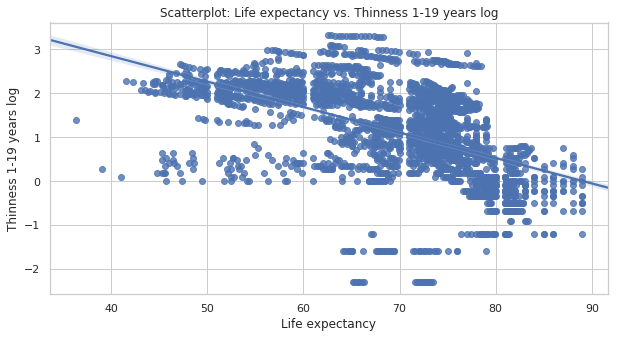

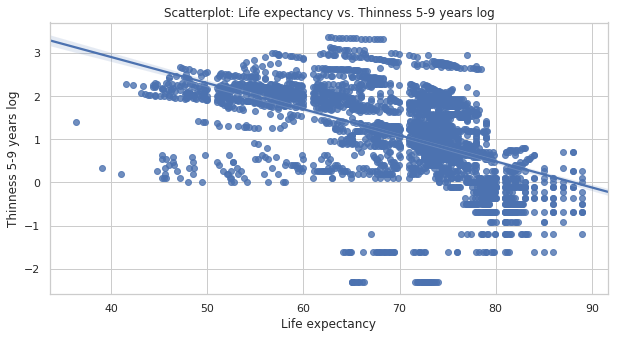

In [876]:
# We don't want to create scatterplots of all of the columns. Skip these--
# they are either categorical data, or we have corrected/transformed versions of them to use instead.
skip_scatterplot = ['Country','Year','Status','Life expectancy','Percentage expenditure','Corrected expenditure',
                    'Measles','Corrected measles','Hiv/aids','Gdp','Thinness 1-19 years','Thinness 5-9 years',
                   ]

scatterplot_vs_life_expectancy(life_df,skip_scatterplot)


At a glance, the strongest positive correlations seem to be with HDI score ("Income consumption of resources") and "Schooling". The HDI score is itself a composite score of life expectancy and some other factors, so this is no surprise. Had I not already found that article the other day about the relationship between education and health, Schooling's high correlation would have been a surprise! Immunizations of all kinds also present a strong positive correlation. GDP also has a positive correlation strong enough to be worth mentioning.

Alcohol and BMI also have a strong positive correlation, which cannot be correct. 

The strongest negative correlations are with adult mortality (no surprise--if lots of adults are dying, their life expectancy will not be long), cases of measles per 1000 population, HIV/AIDS-related deaths in underage children, and thinness of all ages (5-9 and 10-19).

We can also view these correlations as a heatmap. The heatmap gives us a coefficient that helps us compare variables.

Text(0.5, 1.0, 'Correlation matrix (Life expectancy)')

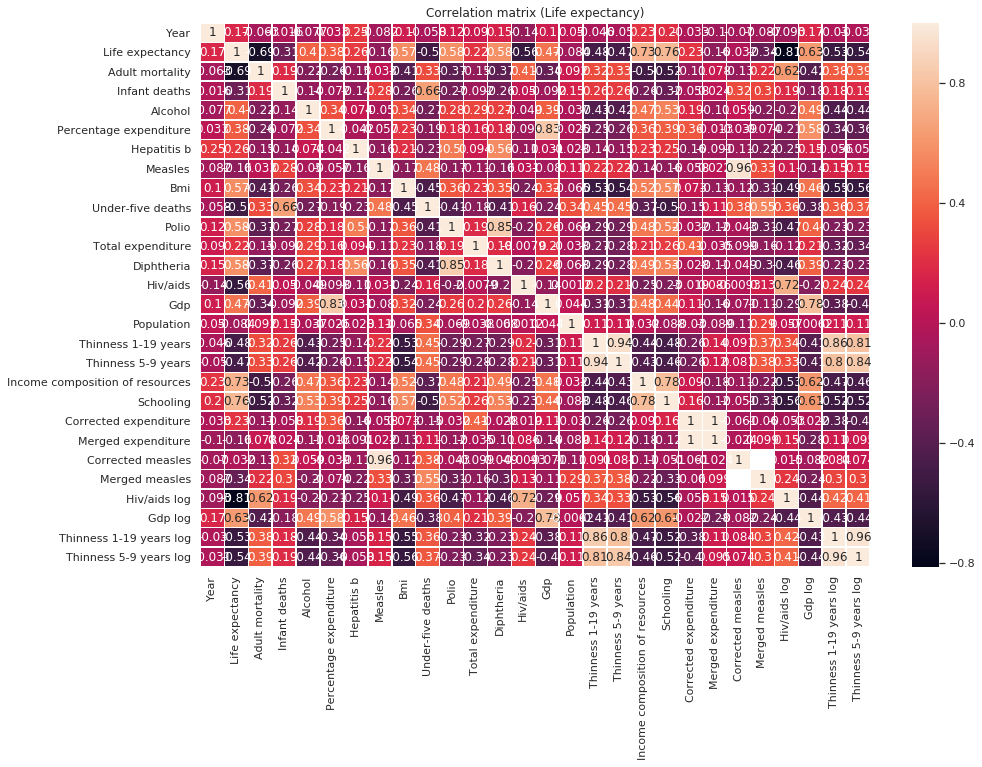

In [880]:
life_corr = life_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(life_corr, annot=True, linewidths=.5)
plt.title("Correlation matrix (Life expectancy)")

## In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

The heatmap confirms what we saw in the scatter plots, but quantifies the strength of the correlations.

__Positive correlation:__
* .4 Liters of pure alcohol consumed!? No. :)
* .57 BMI? Again, no. A high BMI is often related to a host of weight-related health problems.
* __.58 Immunizations (polio, diphtheria)__. Looks like I can choose either of these. Both are not necessary.
* .73 HDI score, aka Income composition of resources. Using an index that already includes life expectancy feels like cheating.
* __.76 Schooling__. Our strongest positive correlation, and as neither a health or (strictly) economic-related variable, it is kind of intriguing.
* __.63 GDP (log-transformed; raw GDP is .47)__. This is the sole economic indicator from the positive or negative lists.

__Negative correlation:__
* -.69 Adult mortality. Too obvious.
* -.5 Under-five deaths. Also has an obvious effect in life expectancy, and not even the strongest of the negative correlations.
* __-.81 HIV/AIDS-related deaths in underage children (age 0-4) (log-transformed; raw HIV/AIDS value is -.56)__. This is too strong a (negative) correlation to pass up.
* __-.53/-.54 Thinness, 5-9 years and 10-19 years (log-transformed; raw thinness values are -.47/-.48)__. One of these, but both are not necessary.

### Feature engineering:
1. Transform your chosen variables to make them normally distributed, best as you can.
2. Normalize these variables.

In [906]:
# Perform a Box-cox transformation on our target variable, to make its distribution more normal
life_expectancy_boxcox,_ = boxcox(life_df['Life expectancy'])

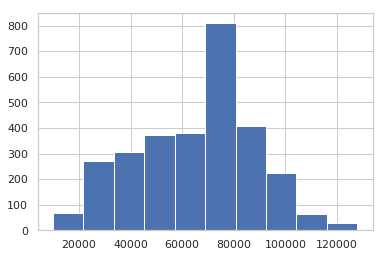

In [907]:
leplt = plt.hist(life_expectancy_boxcox)

__I will choose the Polio variable from the two available immunizations-related variables.__

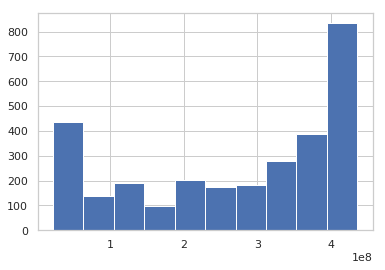

In [917]:
polio_boxcox,_ = boxcox(life_df['Polio'])
pplt = plt.hist(polio_boxcox)

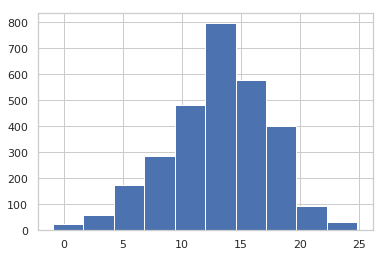

In [918]:
school_boxcox,_ = boxcox(life_df['Schooling'])
schoolplt = plt.hist(school_boxcox)

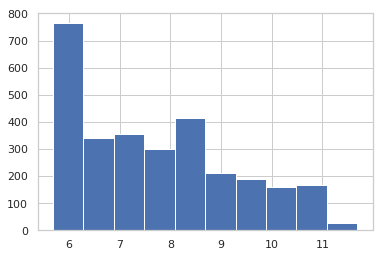

In [921]:
# A log transformation was already applied to GDP in an attempt to make it more normal
gdpplt = plt.hist(life_df['Gdp log'])

In [926]:
life_df['Normalized_life_expectancy'] = normalize(np.array(life_df['Life expectancy']).reshape(1,-1)).reshape(-1,1)
life_df['Normalized_polio'] = normalize(np.array(life_df['Polio']).reshape(1,-1)).reshape(-1,1)
life_df['Normalized_schooling'] = normalize(np.array(life_df['Schooling']).reshape(1,-1)).reshape(-1,1)

life_df['Normalized_gdp'] = normalize(np.array(life_df['Gdp log']).reshape(1,-1)).reshape(-1,1)

So here are our three normalized variables, plotted against a similarly normalized life expectancy:

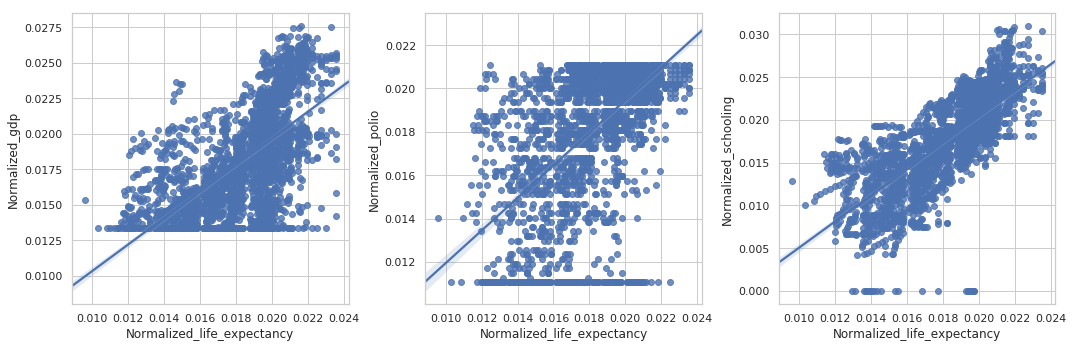

In [937]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.regplot(life_df['Normalized_life_expectancy'],life_df['Normalized_gdp'])
plt.subplot(1,3,2)
sns.regplot(life_df['Normalized_life_expectancy'],life_df['Normalized_polio'])
plt.subplot(1,3,3)
sns.regplot(life_df['Normalized_life_expectancy'],life_df['Normalized_schooling'])
plt.tight_layout()

My attempt to understand PCA...honestly I am cutting and pasting from the checkpoint material. I think PCA is meant to help me understand which variables are the best to keep, when I've already done this work. 

In [942]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(life_df[['Normalized_life_expectancy',
                                            'Normalized_gdp',
                                            'Normalized_polio',
                                            'Normalized_schooling']])

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00034165 0.63078327 0.58020883 0.76172633]
 [0.63078327 1.00034165 0.39577674 0.60841346]
 [0.58020883 0.39577674 1.00034165 0.52238719]
 [0.76172633 0.60841346 0.52238719 1.00034165]]


In [947]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-0.54434983 -0.47637595 -0.44253978 -0.53000732]
Eigenvalue 1: 2.7657064008842775
----------------------------------------
Eigenvector 2: 
[-0.77158109  0.08132219  0.11965237  0.61946157]
Eigenvalue 2: 0.2323339428404573
----------------------------------------
Eigenvector 3: 
[ 0.32707798 -0.66528572 -0.36256478  0.56476693]
Eigenvalue 3: 0.38942755854815375
----------------------------------------
Eigenvector 4: 
[-0.03695781 -0.56907607  0.81141151 -0.12805434]
Eigenvalue 4: 0.613898684676204
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.69119046 0.05806365 0.09732364 0.15342225]


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.69119046 0.15342225 0.09732364 0.05806365]


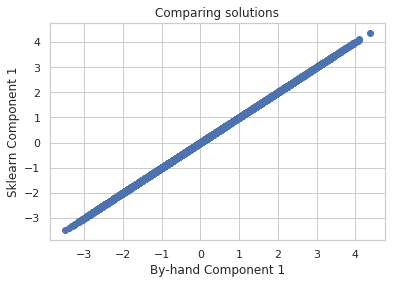

In [948]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

I think I am not totally doing this part correctly--I think Schooling (the last entry below?) is meant to have a better showing here than it does.

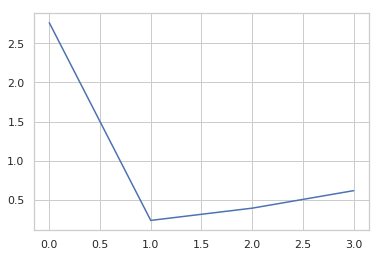

[2.7657064  0.23233394 0.38942756 0.61389868]


In [949]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

## Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [950]:
summary_corr = life_df[['Normalized_life_expectancy',
                        'Normalized_gdp',
                        'Normalized_polio',
                        'Normalized_schooling']].corr()

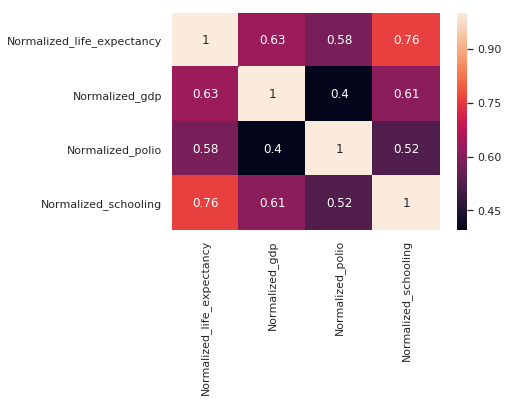

In [952]:
sns.heatmap(summary_corr,annot=True)

# In this dataset, the three factors having the largest effect on life expectancy are a mix of educational, economic, and health concerns:
## 1. [There is a strong correlation between the amount of education a person receives, and their relative health](https://www.newscientist.com/article/2166833-more-education-is-what-makes-people-live-longer-not-more-money/). This is apparently independent of personal wealth.

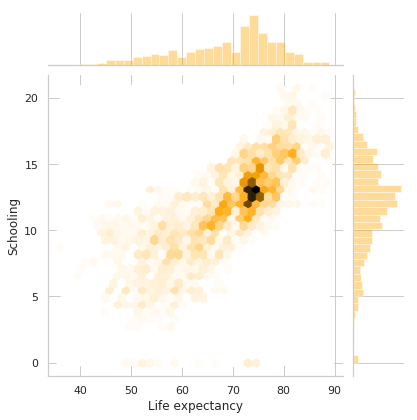

In [961]:
schjp = sns.jointplot(x='Life expectancy',y='Schooling',data=life_df,color='orange',kind='hex',)

## 2. That said, at a national level, a higher GDP per capita is also related to longer life expectancy.

In this graph, there is a full range of life expectancy in countries with a lower GDP per capita, but as GDP grows, longer life expectancies become more frequent.

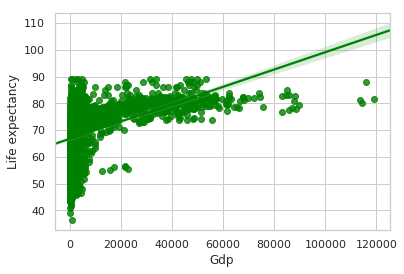

In [973]:
schp = sns.regplot(x='Gdp',y='Life expectancy',data=life_df,color='green')

## 3. Childhood immunization programs, including (but not limited to) programs to eliminate polio and diphtheria, also contribute to longer life expectancy.

The highest concentration of long life expectancy is in countries with the highest childhood immunization rates. In this graph, immunization rates against polio are shown.

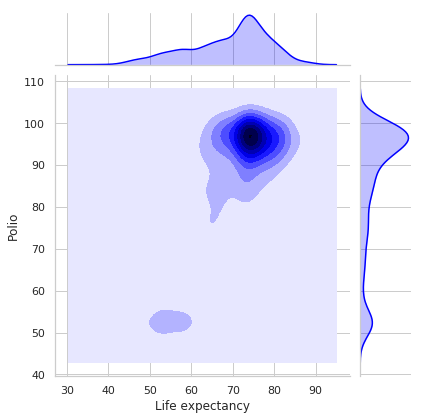

In [987]:
immp = sns.jointplot(y='Polio',x='Life expectancy',data=life_df,color='blue',kind='kde')